In [3]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Conv2D, Conv2DTranspose, Input
from tensorflow.keras.layers import Flatten, BatchNormalization
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.layers import LeakyReLU, Softmax
from tensorflow.keras.optimizers import Adam
from skimage.transform import resize
import matplotlib.pyplot as plt
%matplotlib inline
from warnings import simplefilter
simplefilter(action='ignore', category=UserWarning)
from IPython.display import clear_output
from tqdm.notebook import trange
import time

In [4]:
# Utilities

def get_mnist_images():
    (X_train, _), (X_test, _) = mnist.load_data()
    X_train, X_test = X_train.reshape((-1, 28, 28, 1)), X_test.reshape((-1, 28, 28, 1))
    train_ims = np.asarray([resize(x, (32, 32, 1)) for x in X_train])
    test_ims = np.asarray([resize(x, (32, 32, 1)) for x in X_test])
    X = np.vstack((train_ims, test_ims))
    return X

In [5]:
# GAN Model

class DCGAN():
    
    def __init__(self, data, batch_size=128, learning_rate=1e-03):
        self.data = data
        self.lr = learning_rate
        self.batch_size = batch_size
        # self.generator_input_dim = (1, 1, generator_input_dim)
        # self.discriminator_input_dim = discriminator_input_dim 

        # Initialize all nets
        print("[INFO] Initializing generator and discriminator...")
        self.generator = self.create_generator()
        self.discriminator = self.create_discriminator()

        # Initialize GAN model
        print("[INFO] Initializing GAN...")
        self.GAN = Sequential()
        self.GAN.add(self.generator)
        self.GAN.add(self.discriminator)

        # Compile discriminator and GAN
        print("[INFO] Compiling discriminator and GAN...")
        self.discriminator.compile(loss='binary_crossentropy', optimizer=Adam(lr=10*self.lr))
        self.GAN.compile(loss='binary_crossentropy', optimizer=Adam(lr=self.lr))

        # Pretrain discriminator
        print("[INFO] Pretraining discriminator...\n")
        self.pretrain_discriminator(data_size=10000, epochs=5)
        
    def discriminator_trainable(self, val):
        self.discriminator.trainable = val
        for l in self.discriminator.layers:
            l.trainable = val
        
    def create_generator(self):
        model = Sequential()
        model.add(Conv2DTranspose(512, kernel_size=(3,3), strides=(2,2), activation='relu', padding='same', 
                                  input_shape=(1, 1, 100)))
        model.add(BatchNormalization())
        model.add(Conv2DTranspose(256, kernel_size=(3,3), strides=(2,2), activation='relu', padding='same'))
        model.add(BatchNormalization())
        model.add(Conv2DTranspose(128, kernel_size=(3,3), strides=(2,2), activation='relu', padding='same'))
        model.add(BatchNormalization())
        model.add(Conv2DTranspose(64, kernel_size=(3,3), strides=(2,2), activation='relu', padding='same'))
        model.add(BatchNormalization())
        model.add(Conv2DTranspose(1, kernel_size=(3,3), strides=(2,2), activation='tanh', padding='same'))
        model.add(BatchNormalization())
        return model
        
    def create_discriminator(self):
        model = Sequential()
        model.add(Conv2D(32, kernel_size=(3,3), strides=(2,2), padding='same', activation='relu', 
                         input_shape=(32, 32, 1)))
        model.add(BatchNormalization())
        model.add(Conv2D(64, kernel_size=(3,3), strides=(2,2), padding='same', activation='relu'))
        model.add(BatchNormalization())
        model.add(Conv2D(128, kernel_size=(3,3), strides=(2,2), padding='same', activation='relu'))
        model.add(BatchNormalization())
        model.add(Flatten())
        model.add(Dense(1, activation='sigmoid'))
        return model

    def generate_batch(self, n_samples):
        rand_idx = np.random.randint(0, len(self.data), size=n_samples)
        real_ims = self.data[rand_idx]
        noise = np.random.randint(0, 255, size=(n_samples, 1, 1, 100))
        fake_ims = self.generator.predict(noise)
        labels = np.asarray([0]*n_samples + [1]*n_samples)   # 0 - real, 1 - fake
        x = np.vstack((real_ims, fake_ims))
        return x, labels
    
    def generate_gan_batch(self, n_samples):
        noise = np.random.randint(0, 255, size=(n_samples, 1, 1, 100))
        labels = np.asarray([1]*n_samples)
        return noise, labels

    def test_generator(self, n_samples=1):
        rand_noise = np.random.randint(0, 255, size=(n_samples, 1, 1, 100))
        ims = self.generator.predict(rand_noise)
        plt.imshow(ims.reshape(32, 32), cmap='gray')
        plt.show()

    def pretrain_discriminator(self, data_size=10000, epochs=5):
        rand_idx = np.random.randint(0, len(self.data), size=data_size)
        real_ims = self.data[rand_idx]
        noise = np.random.randint(0, 255, size=(data_size, 1, 1, 100))
        fake_ims = self.generator.predict(noise)
        labels = np.asarray([0]*data_size + [1]*data_size)
        x = np.vstack((real_ims, fake_ims))
        # Train discriminator
        self.discriminator.fit(x, labels, epochs=epochs)
        print("\nNow waiting for 5 sec...")
        time.sleep(5)
        clear_output()
            
    def train(self, epochs, iterations):
        for ep in range(epochs):
            print("\nEpoch {}".format(ep+1))
            
            for i in trange(iterations):
                # Generate batch
                x, y = self.generate_batch(self.batch_size // 2)
                # Train discriminator
                self.discriminator.train_on_batch(x, y)
                # Make discriminator untrainable
                self.discriminator_trainable(False)
                # Generate training batch for entire GAN
                x_gan, y_gan = self.generate_gan_batch(self.batch_size)
                # Train GAN model
                self.GAN.train_on_batch(x_gan, y_gan)
                # Make discriminator trainable
                self.discriminator_trainable(True)
            
            # Display image to test generator performance
            self.test_generator(n_samples=1)
            print('')

In [6]:
# Download images
img_data = get_mnist_images()


Epoch 1


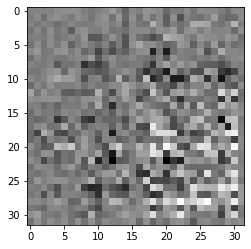



Epoch 2


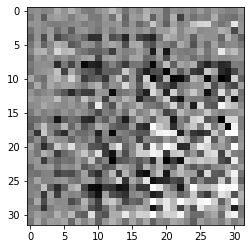



Epoch 3


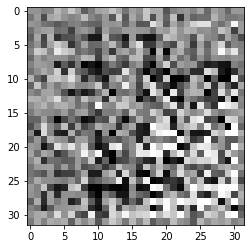



Epoch 4


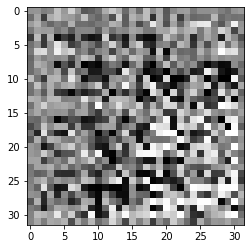



Epoch 5


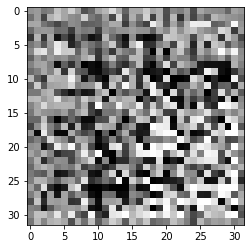



Epoch 6


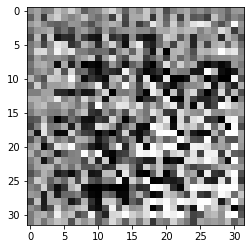



Epoch 7


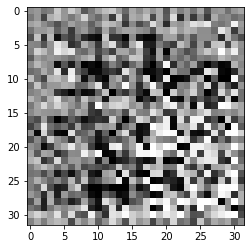



Epoch 8


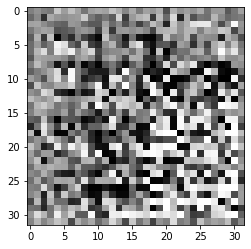



Epoch 9


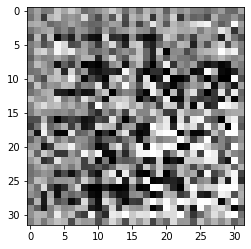



Epoch 10


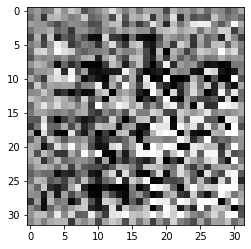



Epoch 11


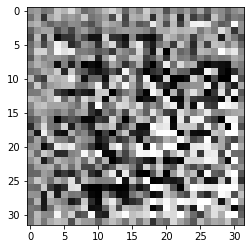



Epoch 12


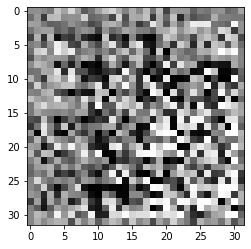



Epoch 13


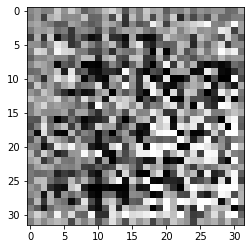



Epoch 14


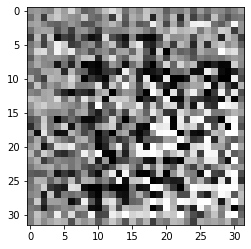



Epoch 15


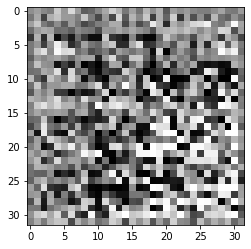



Epoch 16


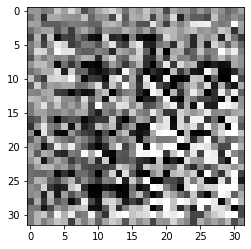



Epoch 17


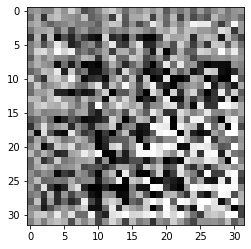



Epoch 18


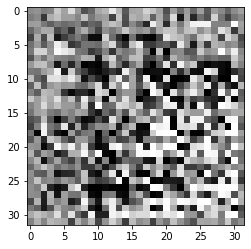



Epoch 19


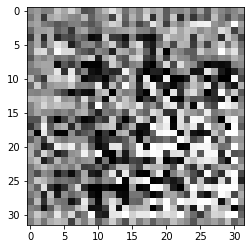



Epoch 20


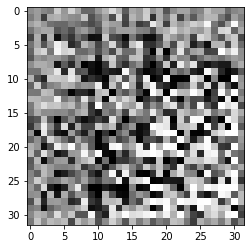



Epoch 21


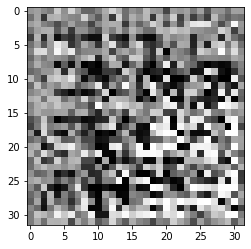



Epoch 22


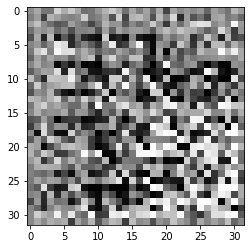



Epoch 23


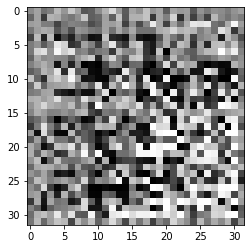



Epoch 24


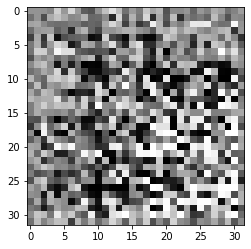



Epoch 25


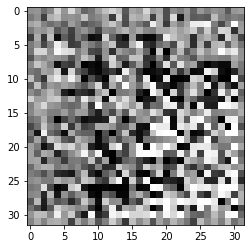



Epoch 26


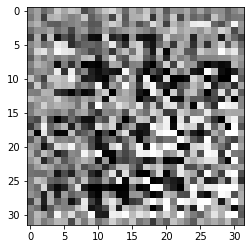



Epoch 27


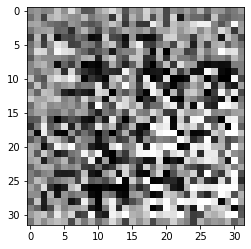



Epoch 28


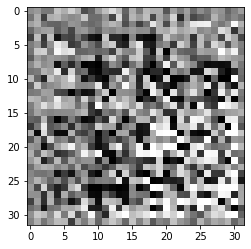



Epoch 29


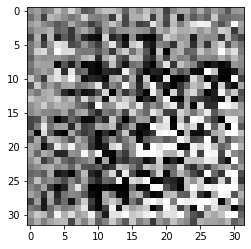



Epoch 30


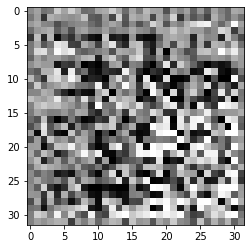



Epoch 31


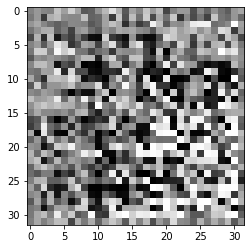



Epoch 32


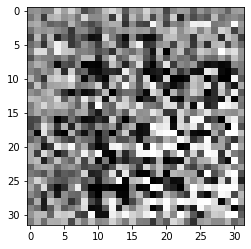



Epoch 33


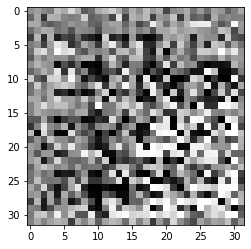



Epoch 34


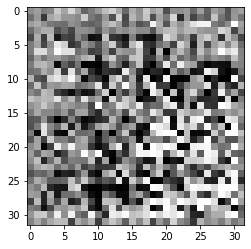



Epoch 35


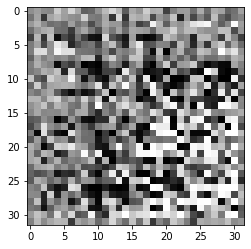



Epoch 36


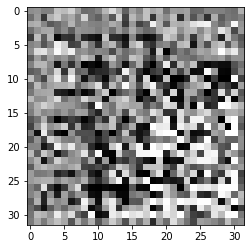



Epoch 37


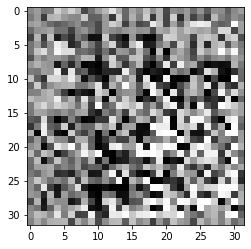



Epoch 38


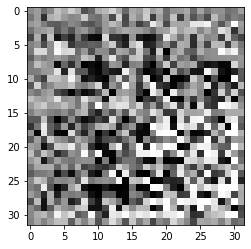



Epoch 39


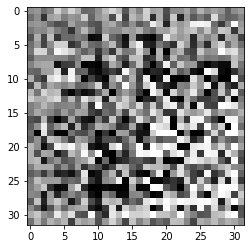



Epoch 40


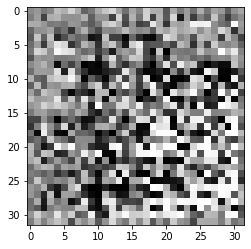



Epoch 41


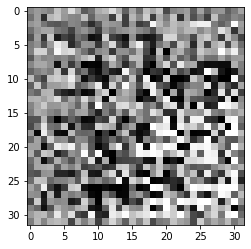



Epoch 42


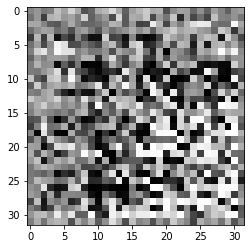



Epoch 43


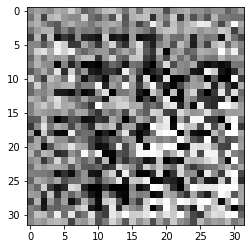



Epoch 44


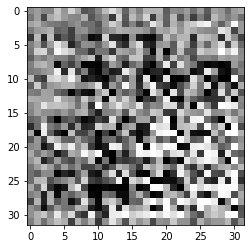



Epoch 45


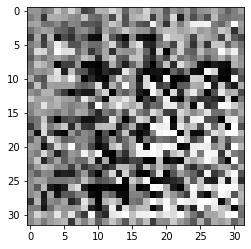



Epoch 46


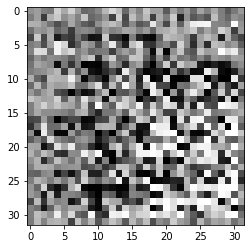



Epoch 47


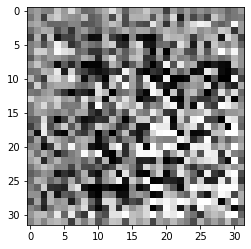



Epoch 48


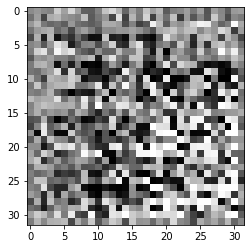



Epoch 49


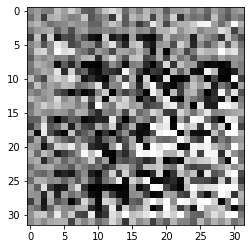



Epoch 50


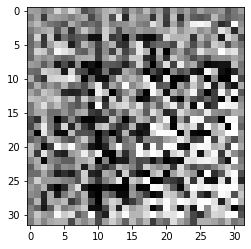



Epoch 51


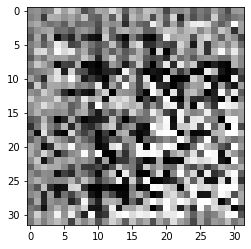



Epoch 52


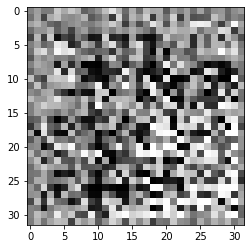



Epoch 53


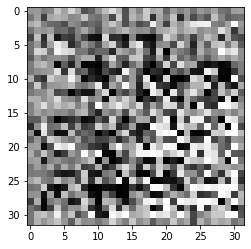



Epoch 54


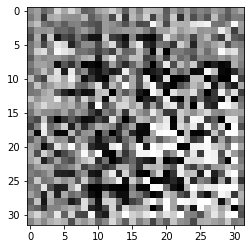



Epoch 55


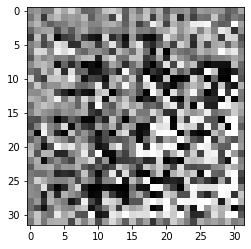



Epoch 56


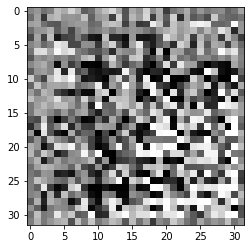



Epoch 57


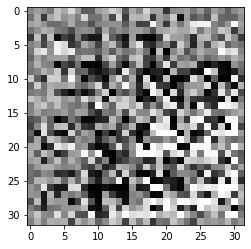



Epoch 58


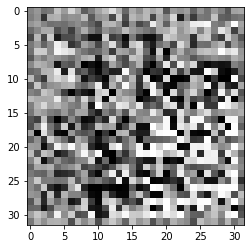



Epoch 59


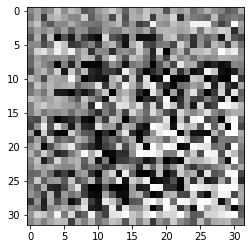



Epoch 60


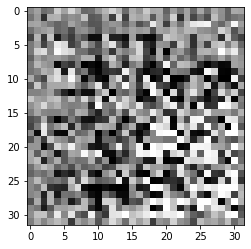



Epoch 61


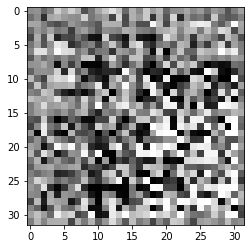



Epoch 62


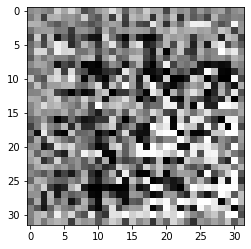



Epoch 63


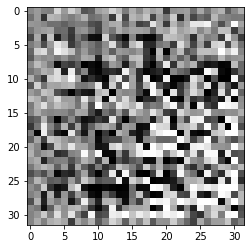



Epoch 64


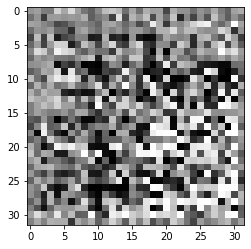



Epoch 65


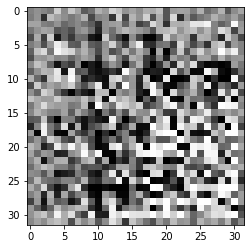



Epoch 66


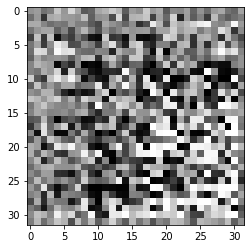



Epoch 67


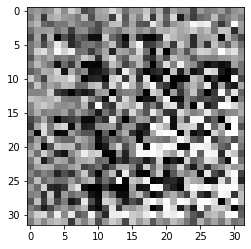



Epoch 68


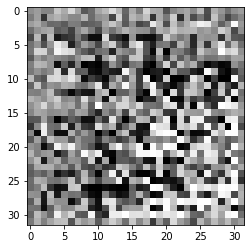



Epoch 69


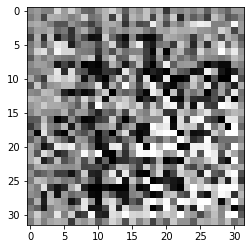



Epoch 70


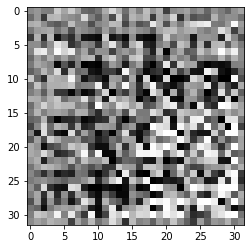



Epoch 71


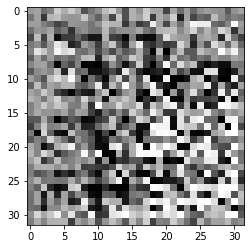



Epoch 72


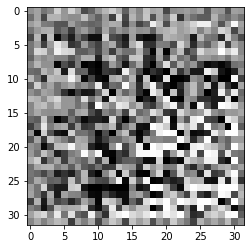



Epoch 73


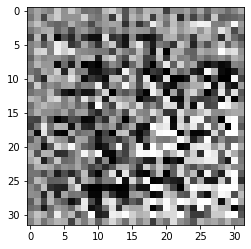



Epoch 74


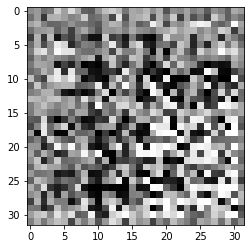



Epoch 75


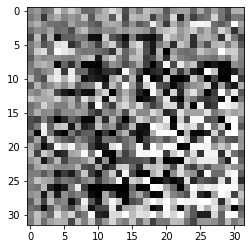



Epoch 76


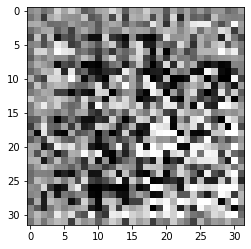



Epoch 77


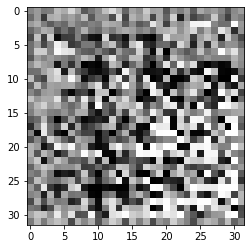



Epoch 78


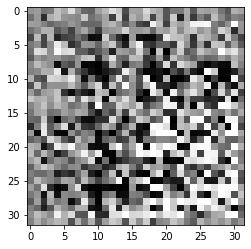



Epoch 79


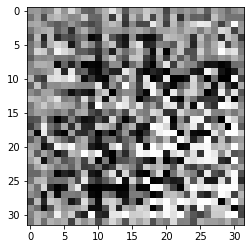



Epoch 80


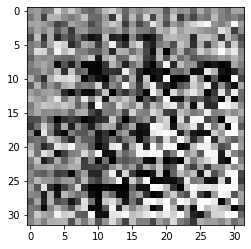



Epoch 81


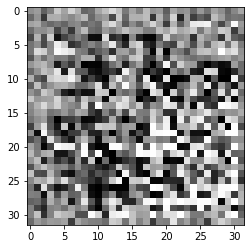



Epoch 82


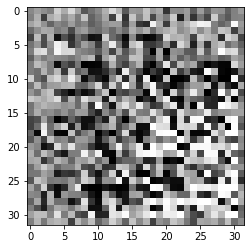



Epoch 83


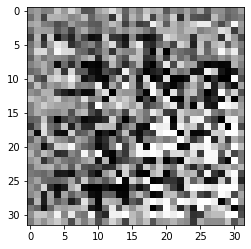



Epoch 84


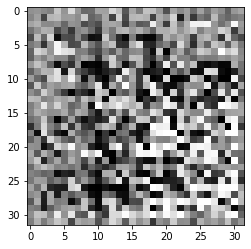



Epoch 85


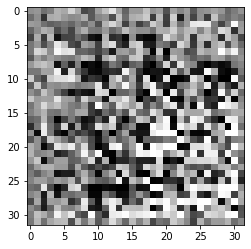



Epoch 86


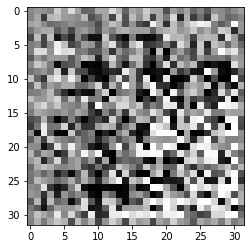



Epoch 87


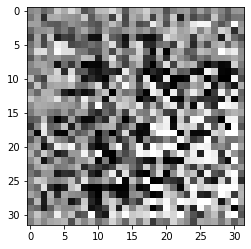



Epoch 88


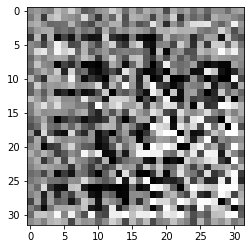



Epoch 89


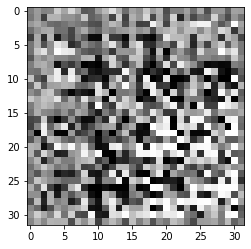



Epoch 90


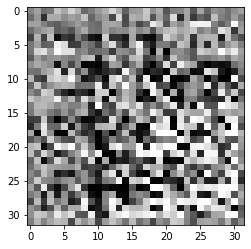



Epoch 91


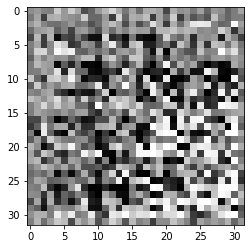



Epoch 92


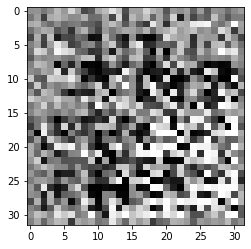



Epoch 93


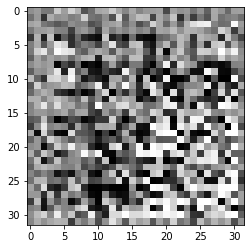



Epoch 94


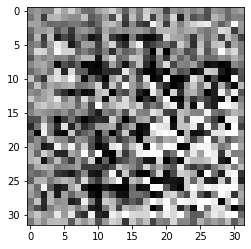



Epoch 95


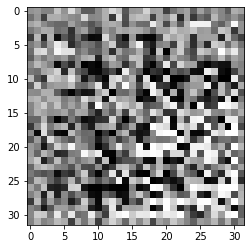



Epoch 96


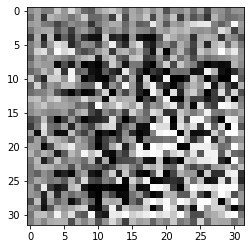



Epoch 97


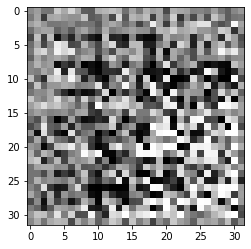



Epoch 98


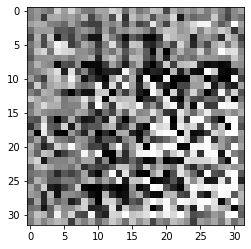



Epoch 99


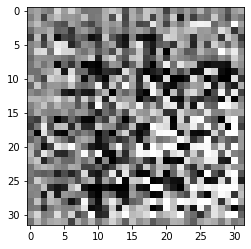



Epoch 100


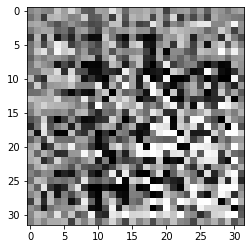



Epoch 101


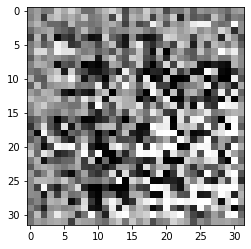



Epoch 102


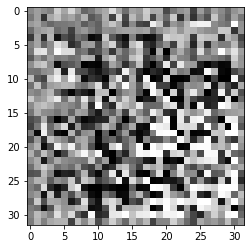



Epoch 103


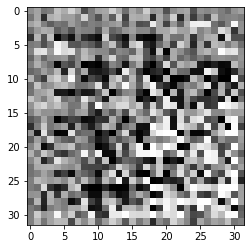



Epoch 104


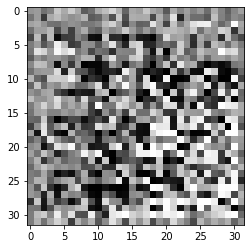



Epoch 105


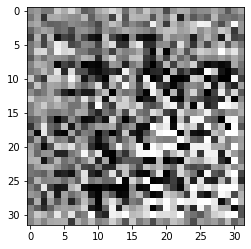



Epoch 106


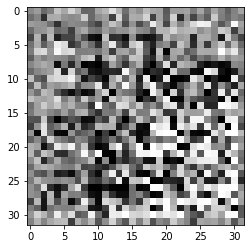



Epoch 107


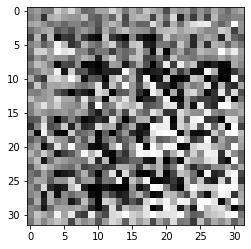



Epoch 108


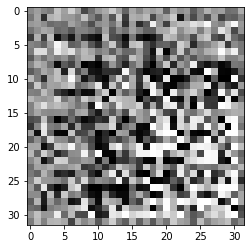



Epoch 109


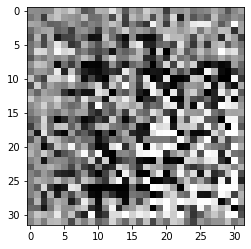



Epoch 110


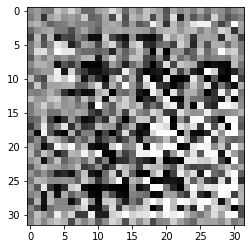



Epoch 111


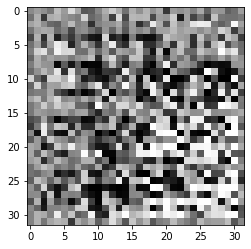



Epoch 112


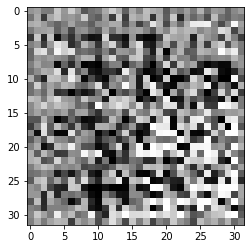



Epoch 113


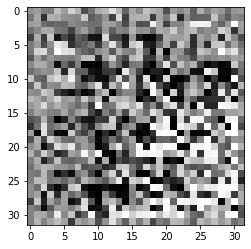



Epoch 114


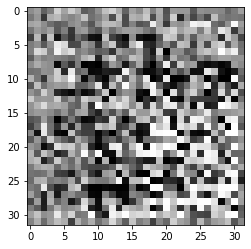



Epoch 115


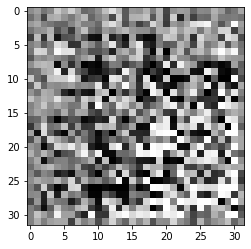



Epoch 116


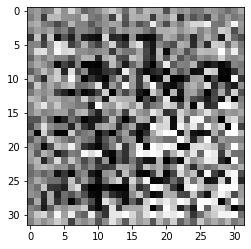



Epoch 117


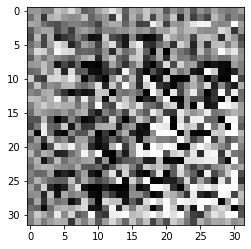



Epoch 118


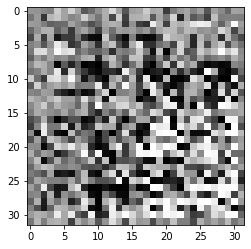



Epoch 119


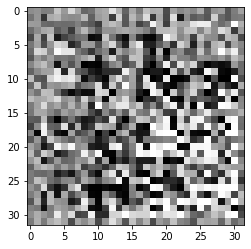



Epoch 120


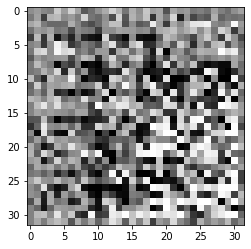



Epoch 121


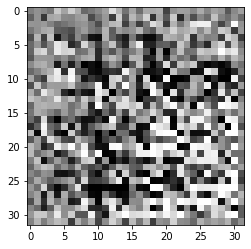



Epoch 122


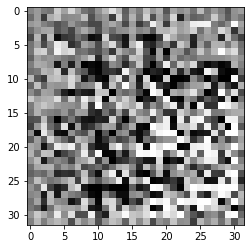



Epoch 123


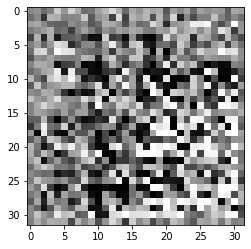



Epoch 124


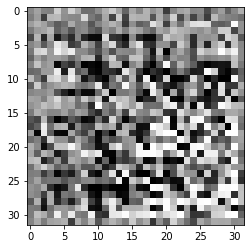



Epoch 125


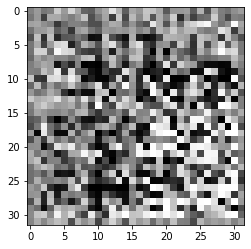



Epoch 126


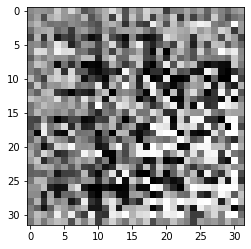



Epoch 127


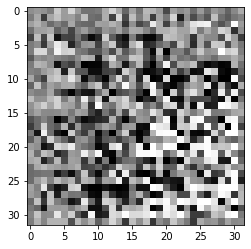



Epoch 128


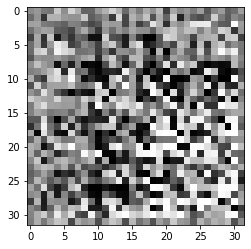



Epoch 129


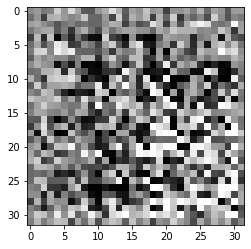



Epoch 130


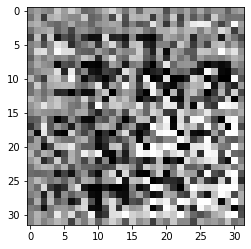



Epoch 131


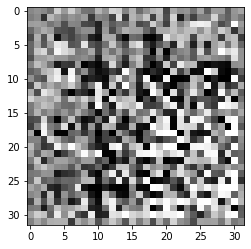



Epoch 132


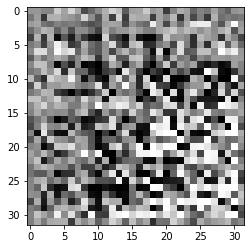



Epoch 133


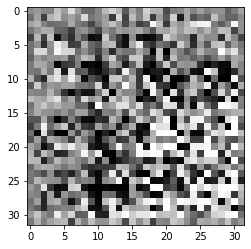



Epoch 134


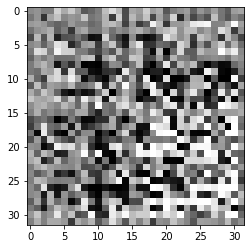



Epoch 135


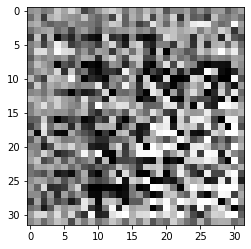



Epoch 136


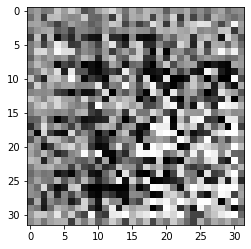



Epoch 137


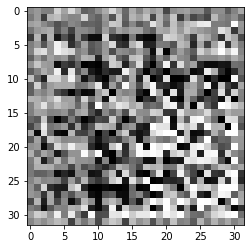



Epoch 138


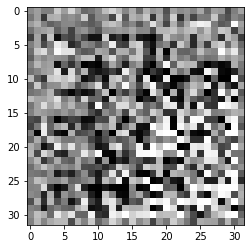



Epoch 139


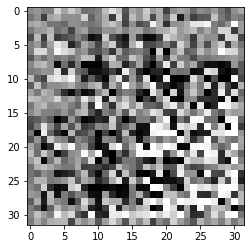



Epoch 140


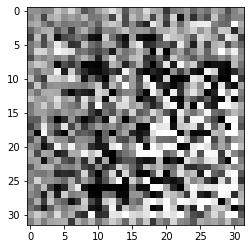



Epoch 141


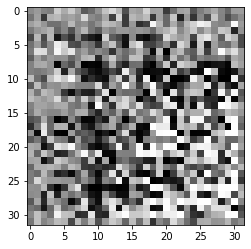



Epoch 142


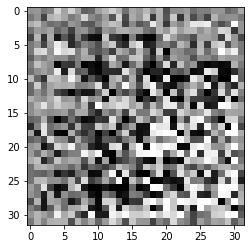



Epoch 143


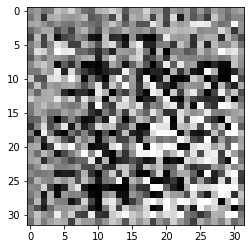



Epoch 144


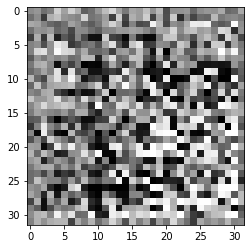



Epoch 145


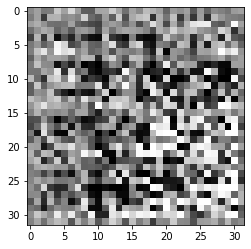



Epoch 146


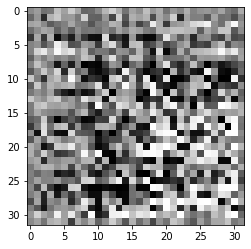



Epoch 147


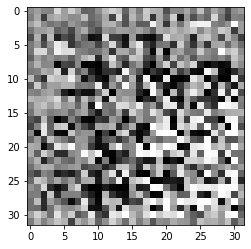



Epoch 148


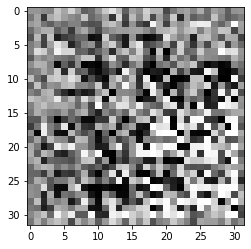



Epoch 149


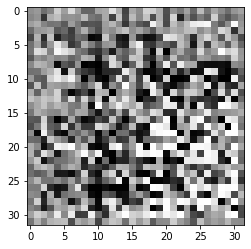



Epoch 150


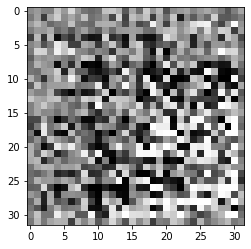



Epoch 151


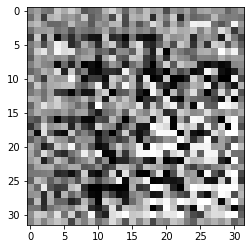



Epoch 152


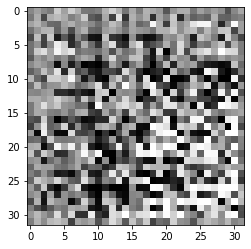



Epoch 153


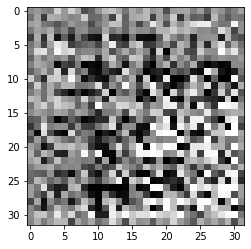



Epoch 154


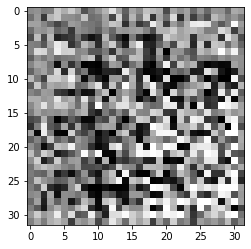



Epoch 155


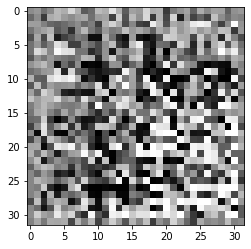



Epoch 156


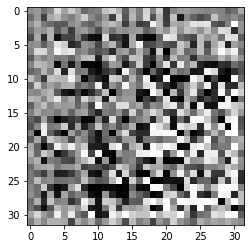



Epoch 157


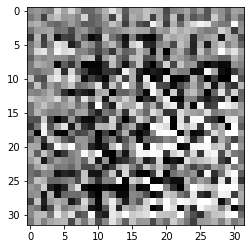



Epoch 158


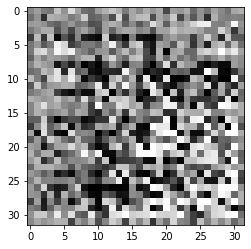



Epoch 159


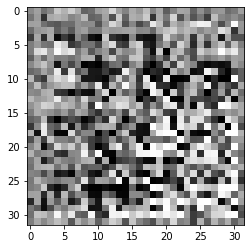



Epoch 160


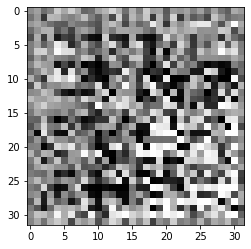



Epoch 161


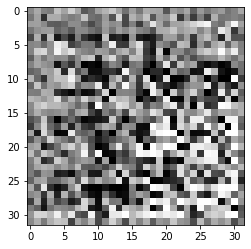



Epoch 162


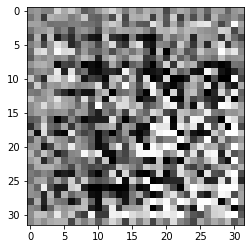



Epoch 163


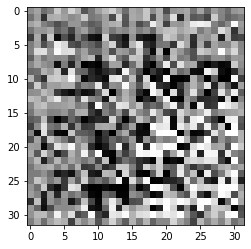



Epoch 164


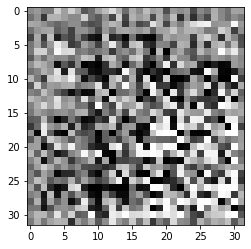



Epoch 165


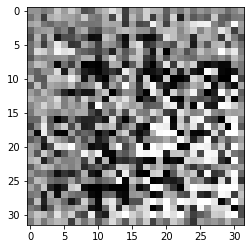



Epoch 166


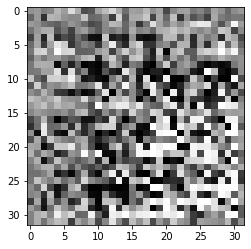



Epoch 167


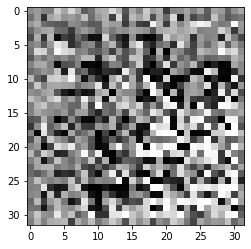



Epoch 168


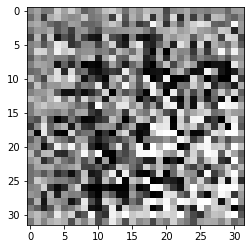



Epoch 169


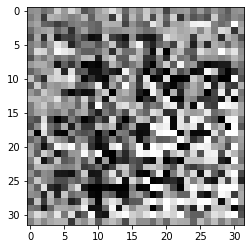



Epoch 170


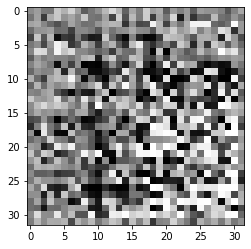



Epoch 171


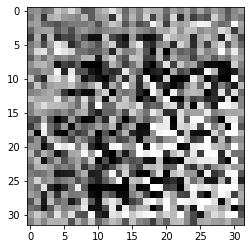



Epoch 172


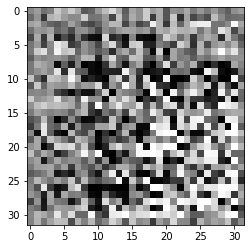



Epoch 173


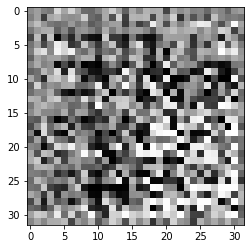



Epoch 174


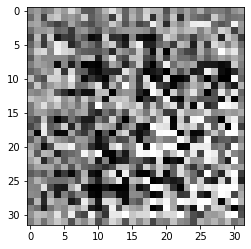



Epoch 175


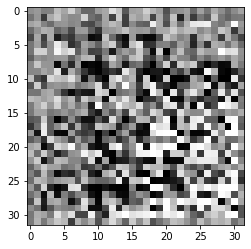



Epoch 176


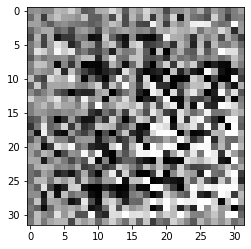



Epoch 177


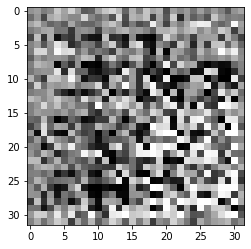



Epoch 178


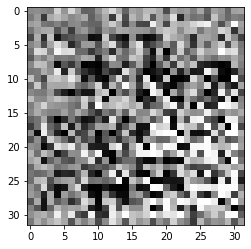



Epoch 179


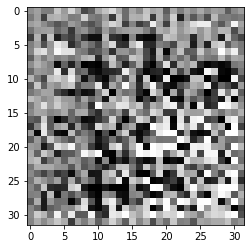



Epoch 180


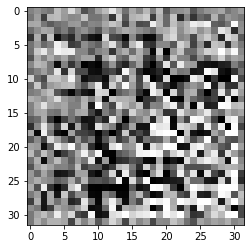



Epoch 181


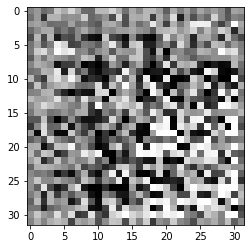



Epoch 182


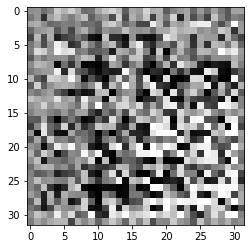



Epoch 183


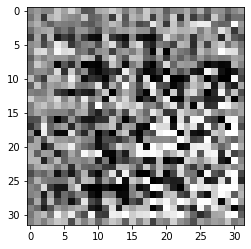



Epoch 184


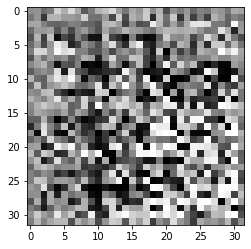



Epoch 185


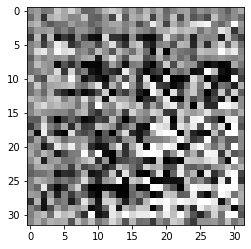



Epoch 186


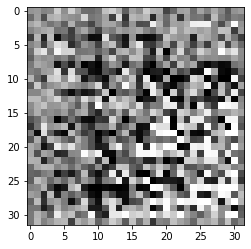



Epoch 187


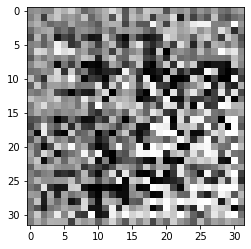



Epoch 188


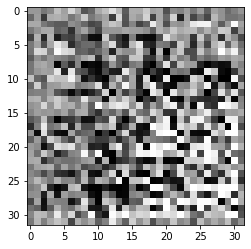



Epoch 189


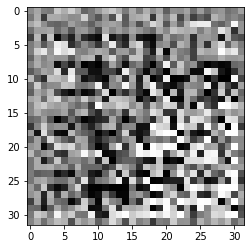



Epoch 190


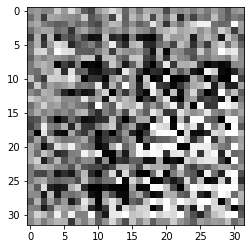



Epoch 191


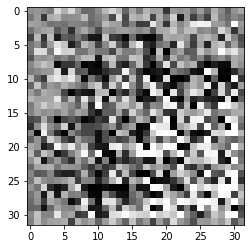



Epoch 192


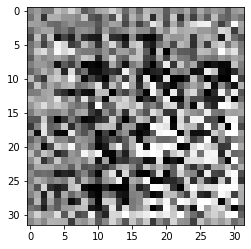



Epoch 193


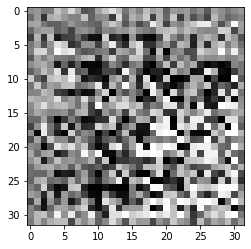



Epoch 194


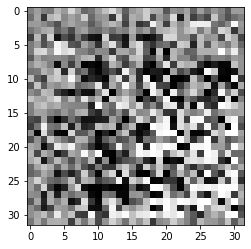



Epoch 195


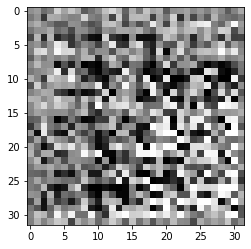



Epoch 196


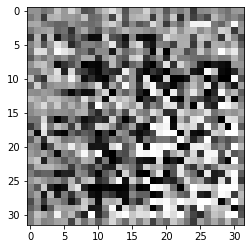



Epoch 197


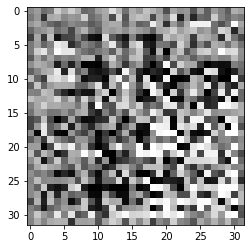



Epoch 198


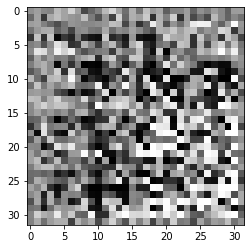



Epoch 199


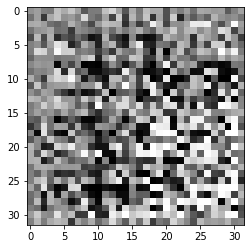



Epoch 200


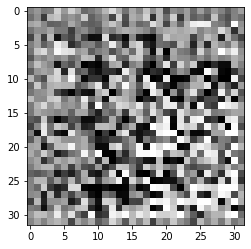



Epoch 201


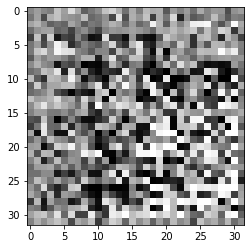



Epoch 202


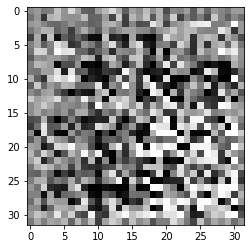



Epoch 203


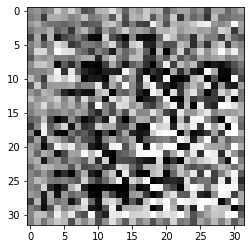



Epoch 204


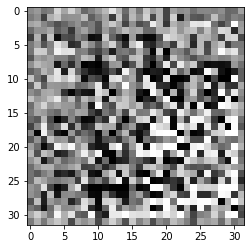



Epoch 205


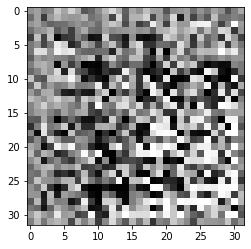



Epoch 206


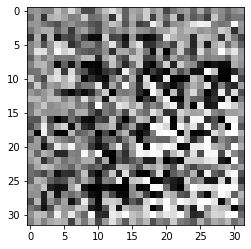



Epoch 207


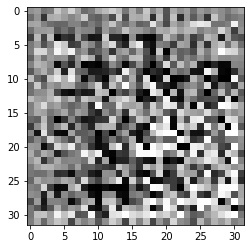



Epoch 208


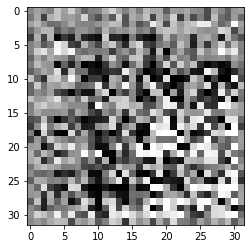



Epoch 209


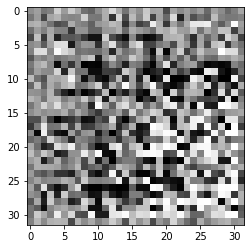



Epoch 210


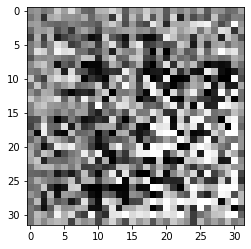



Epoch 211


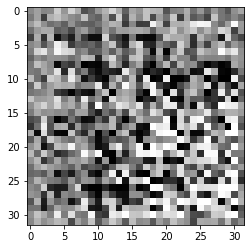



Epoch 212


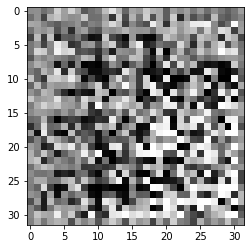



Epoch 213


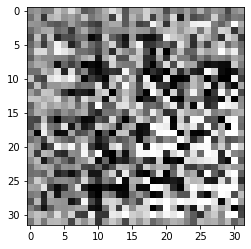



Epoch 214


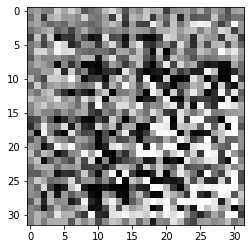



Epoch 215


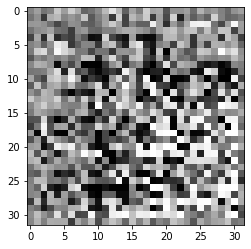



Epoch 216


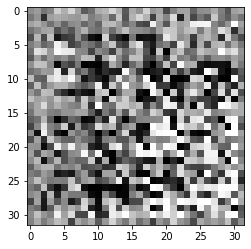



Epoch 217


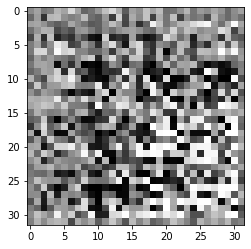



Epoch 218


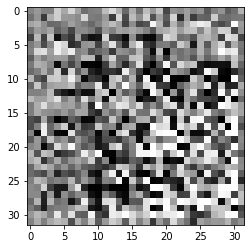



Epoch 219


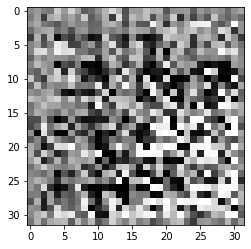



Epoch 220


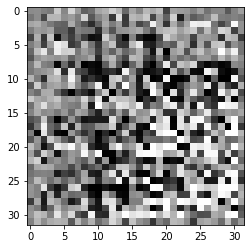



Epoch 221


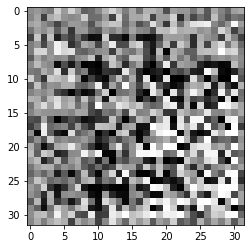



Epoch 222


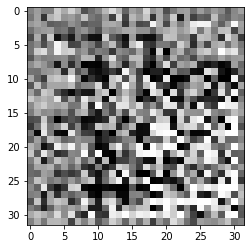



Epoch 223


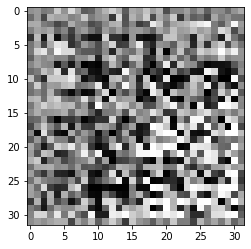



Epoch 224


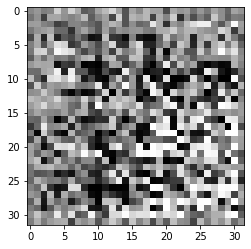



Epoch 225


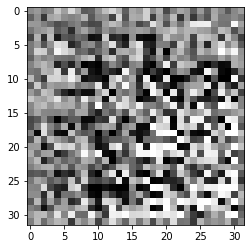



Epoch 226


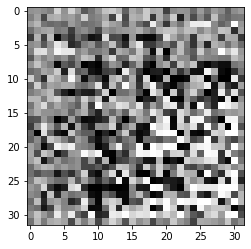



Epoch 227


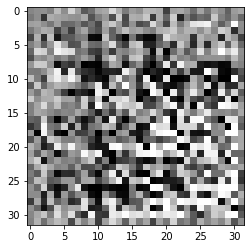



Epoch 228


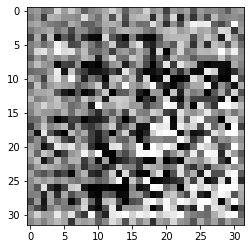



Epoch 229


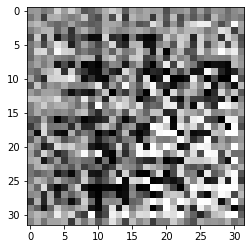



Epoch 230


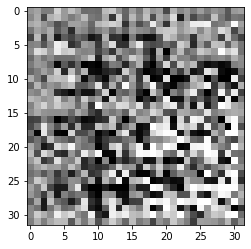



Epoch 231


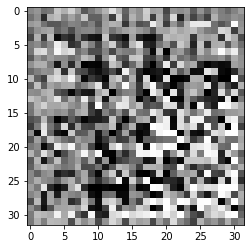



Epoch 232


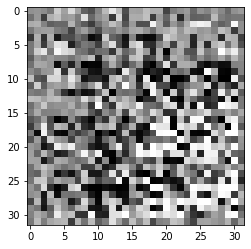



Epoch 233


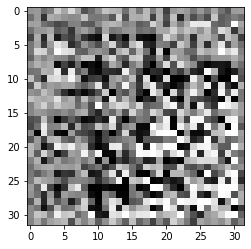



Epoch 234


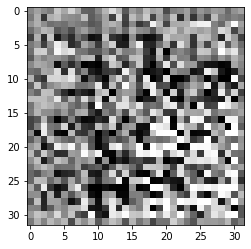



Epoch 235


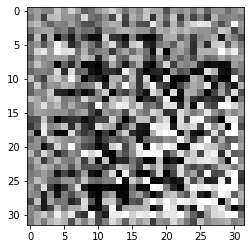



Epoch 236


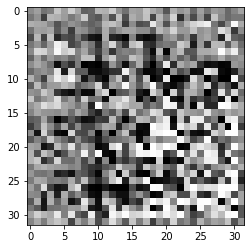



Epoch 237


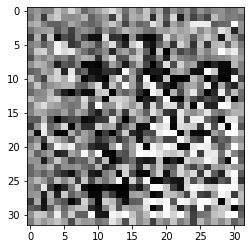



Epoch 238


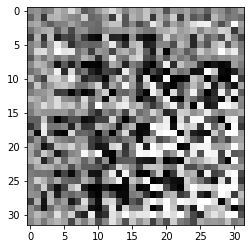



Epoch 239


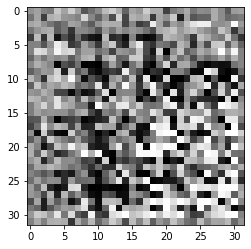



Epoch 240


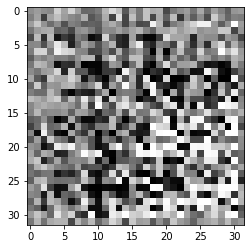



Epoch 241


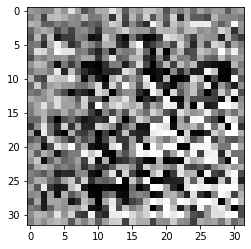



Epoch 242


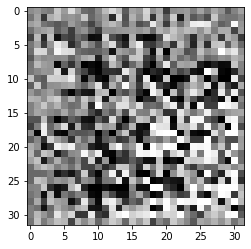



Epoch 243


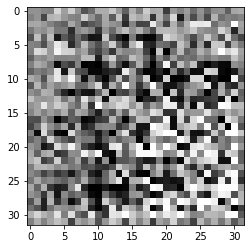



Epoch 244


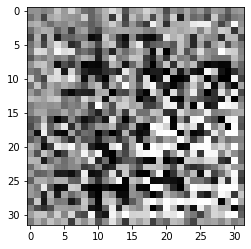



Epoch 245


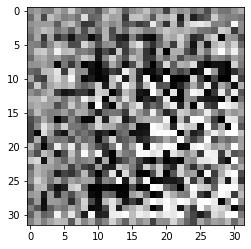



Epoch 246


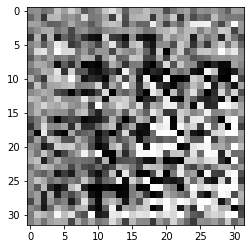



Epoch 247


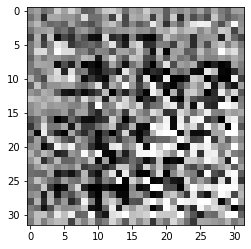



Epoch 248


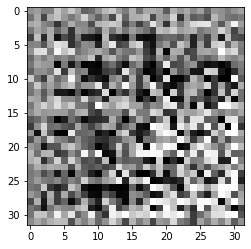



Epoch 249


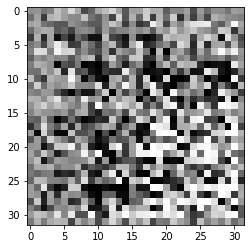



Epoch 250


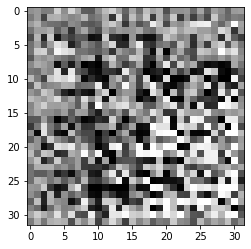



Epoch 251


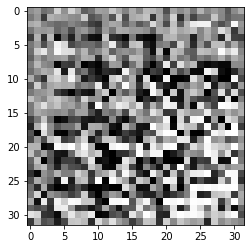



Epoch 252


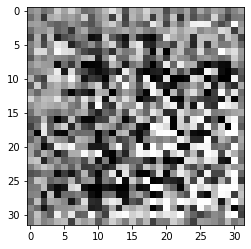



Epoch 253


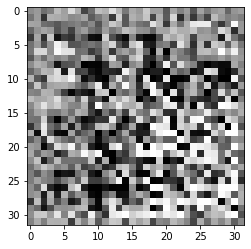



Epoch 254


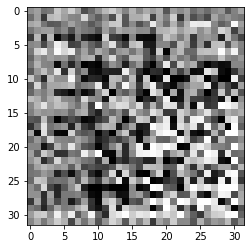



Epoch 255


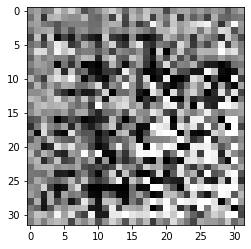



Epoch 256


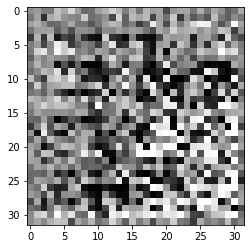



Epoch 257


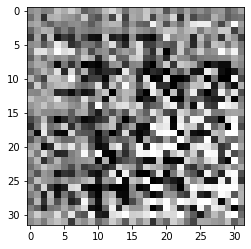



Epoch 258


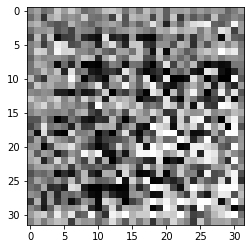



Epoch 259


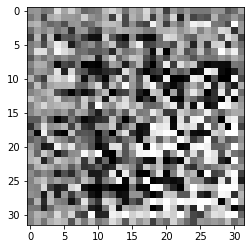



Epoch 260


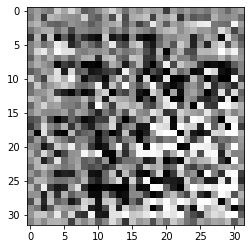



Epoch 261


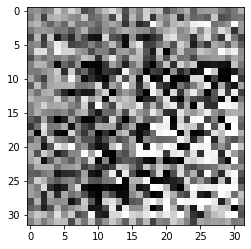



Epoch 262


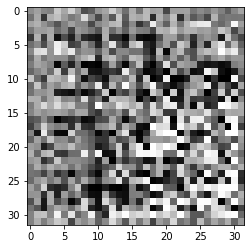



Epoch 263


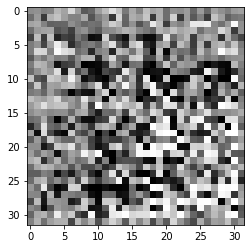



Epoch 264


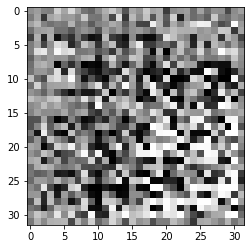



Epoch 265


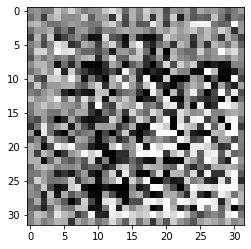



Epoch 266


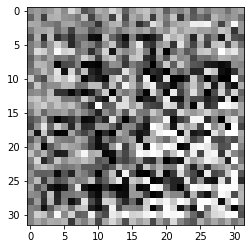



Epoch 267


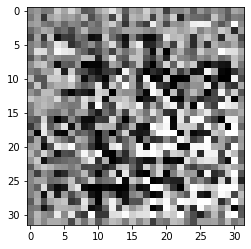



Epoch 268


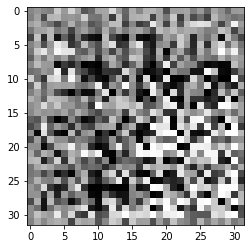



Epoch 269


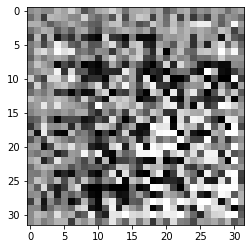



Epoch 270


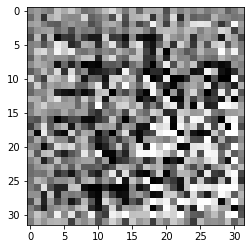



Epoch 271


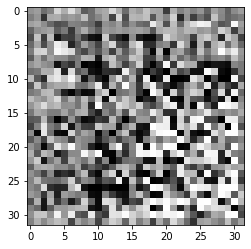



Epoch 272


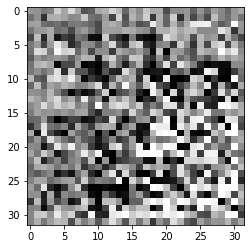



Epoch 273


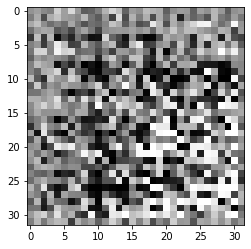



Epoch 274


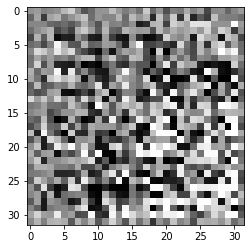



Epoch 275


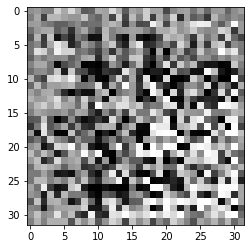



Epoch 276


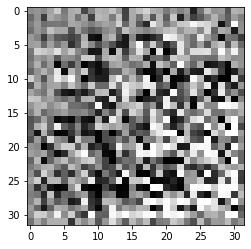



Epoch 277


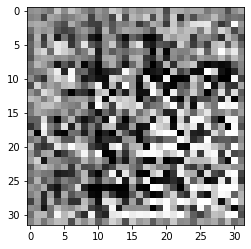



Epoch 278


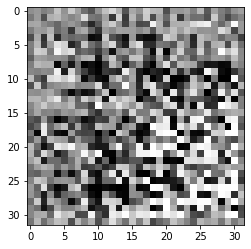



Epoch 279


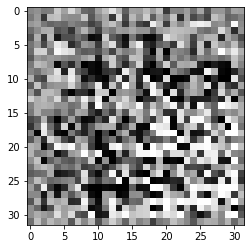



Epoch 280


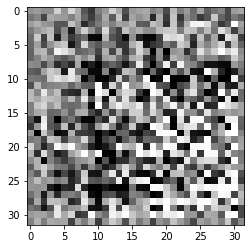



Epoch 281


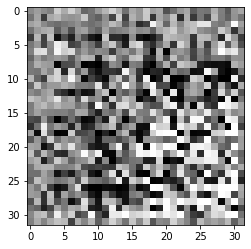



Epoch 282


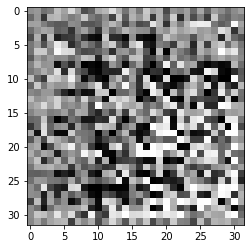



Epoch 283


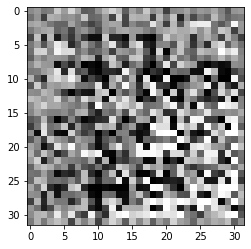



Epoch 284


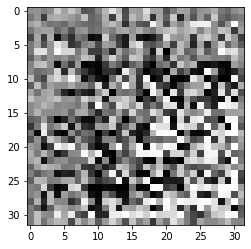



Epoch 285


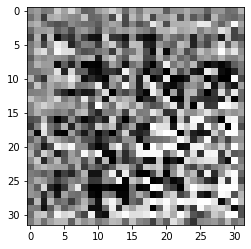



Epoch 286


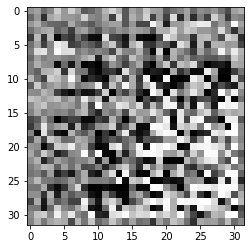



Epoch 287


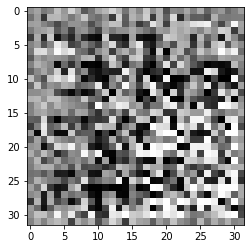



Epoch 288


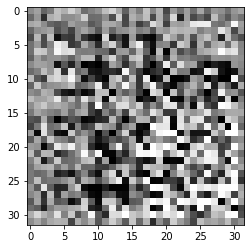



Epoch 289


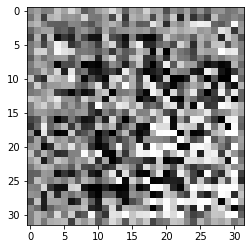



Epoch 290


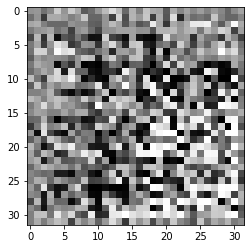



Epoch 291


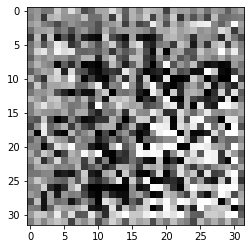



Epoch 292


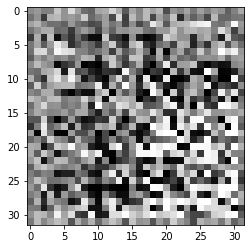



Epoch 293


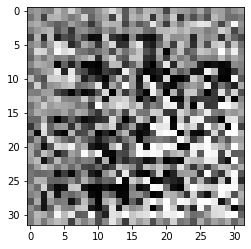



Epoch 294


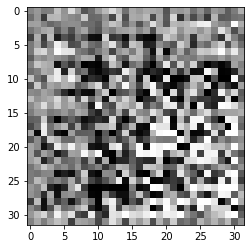



Epoch 295


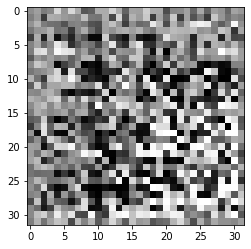



Epoch 296


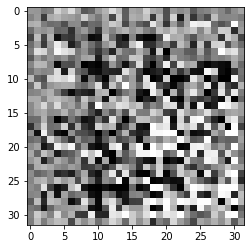



Epoch 297


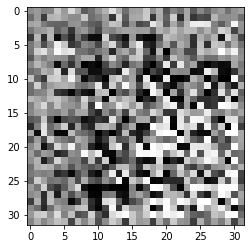



Epoch 298


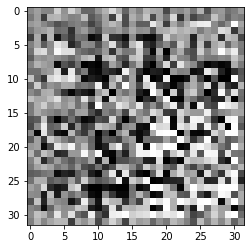



Epoch 299


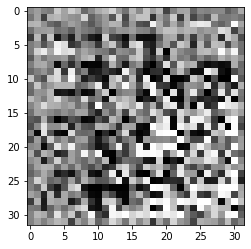



Epoch 300


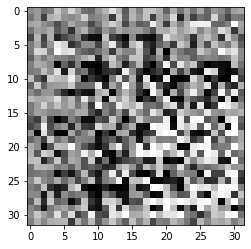



Epoch 301


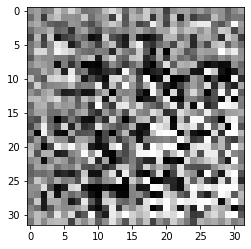



Epoch 302


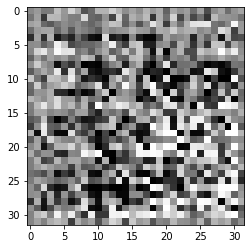



Epoch 303


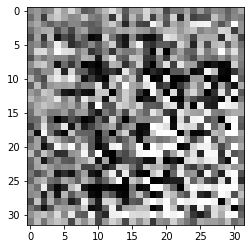



Epoch 304


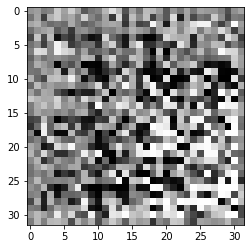



Epoch 305


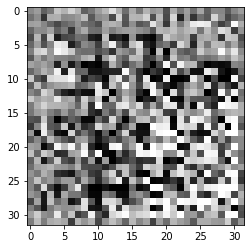



Epoch 306


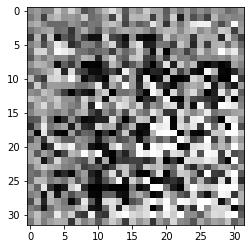



Epoch 307


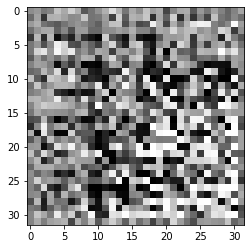



Epoch 308


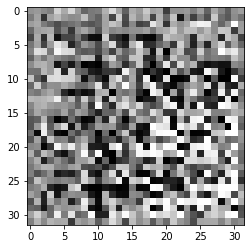



Epoch 309


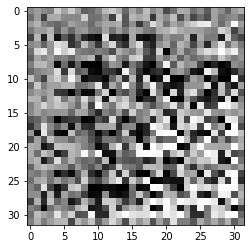



Epoch 310


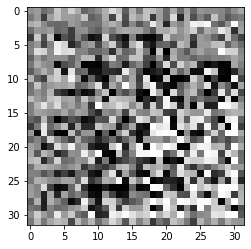



Epoch 311


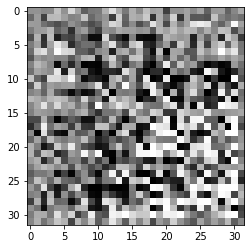



Epoch 312


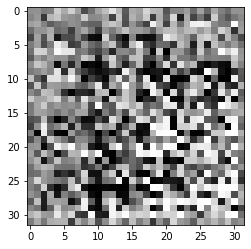



Epoch 313


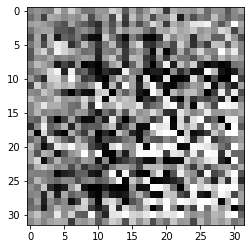



Epoch 314


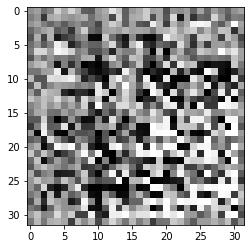



Epoch 315


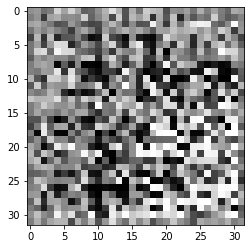



Epoch 316


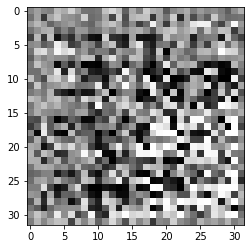



Epoch 317


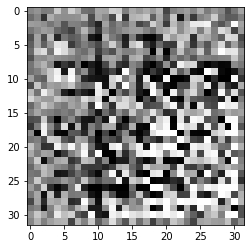



Epoch 318


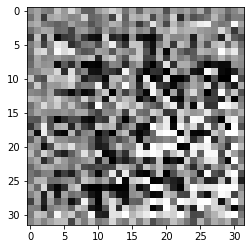



Epoch 319


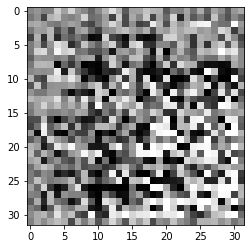



Epoch 320


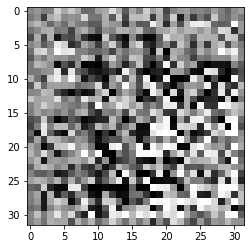



Epoch 321


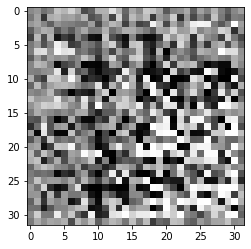



Epoch 322


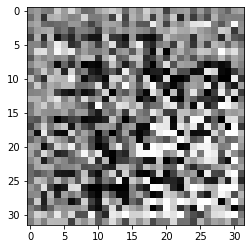



Epoch 323


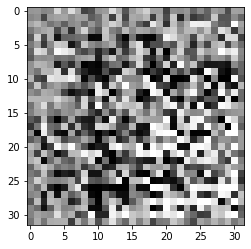



Epoch 324


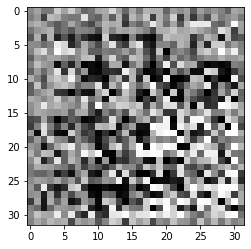



Epoch 325


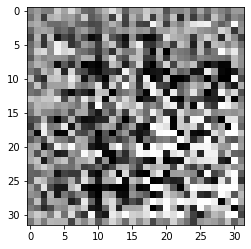



Epoch 326


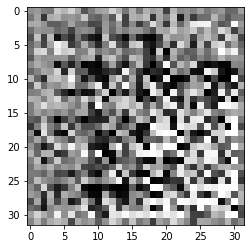



Epoch 327


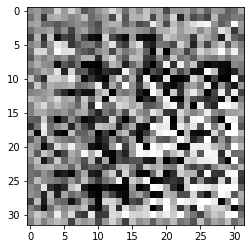



Epoch 328


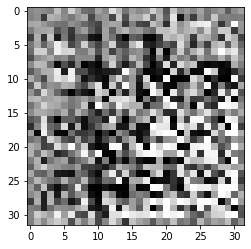



Epoch 329


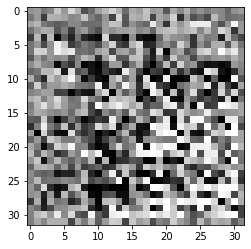



Epoch 330


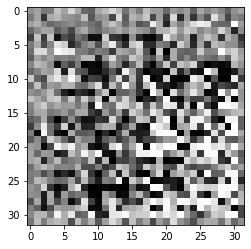



Epoch 331


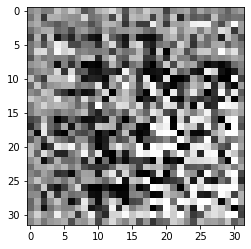



Epoch 332


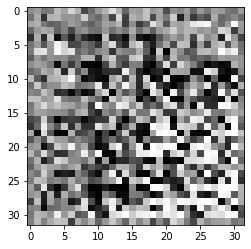



Epoch 333


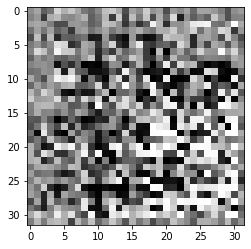



Epoch 334


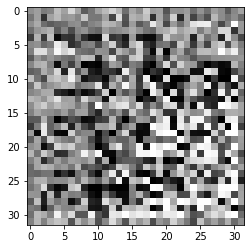



Epoch 335


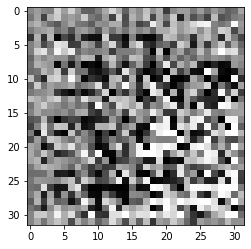



Epoch 336


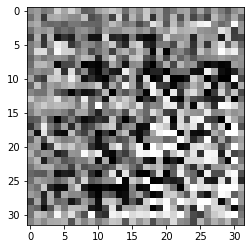



Epoch 337


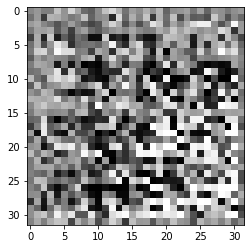



Epoch 338


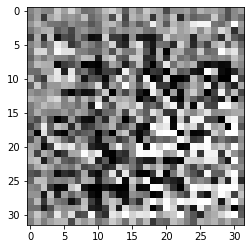



Epoch 339


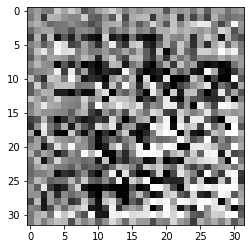



Epoch 340


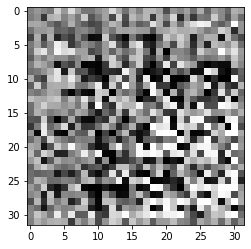



Epoch 341


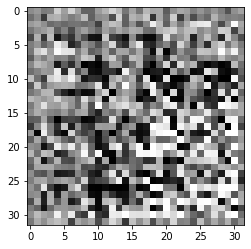



Epoch 342


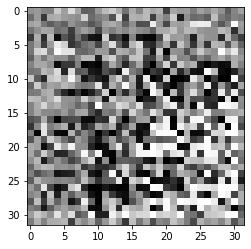



Epoch 343


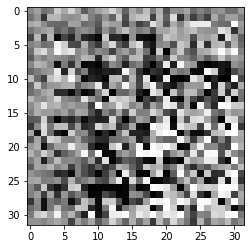



Epoch 344


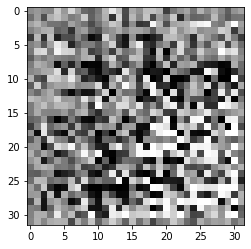



Epoch 345


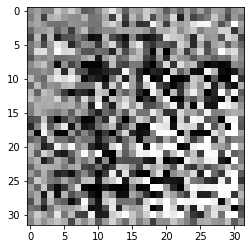



Epoch 346


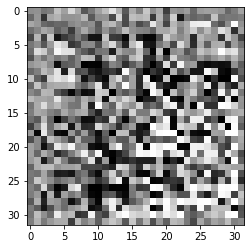



Epoch 347


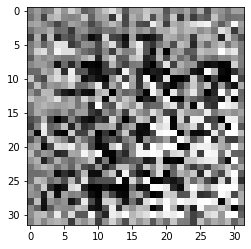



Epoch 348


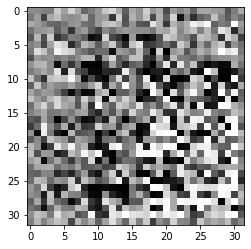



Epoch 349


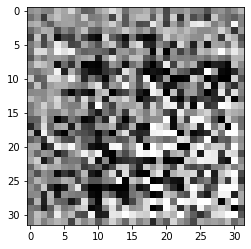



Epoch 350


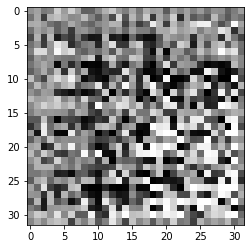



Epoch 351


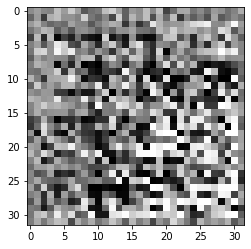



Epoch 352


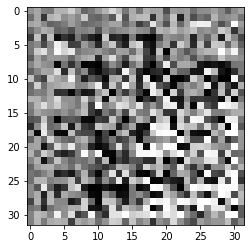



Epoch 353


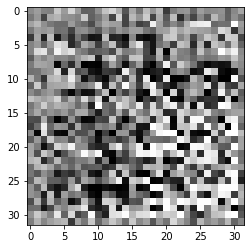



Epoch 354


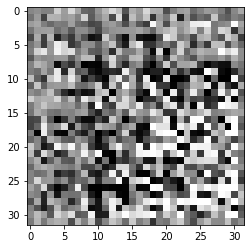



Epoch 355


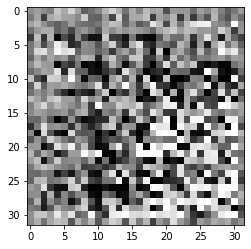



Epoch 356


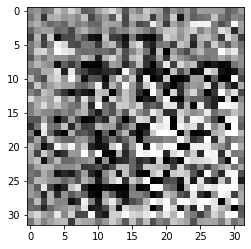



Epoch 357


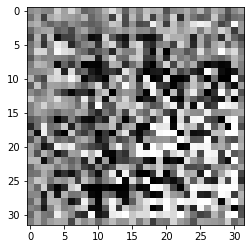



Epoch 358


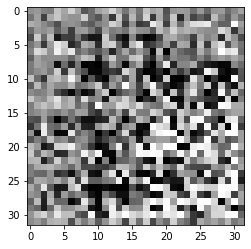



Epoch 359


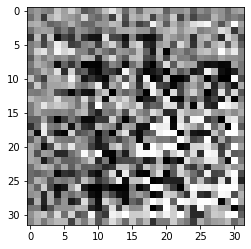



Epoch 360


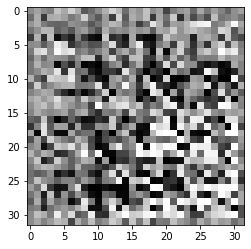



Epoch 361


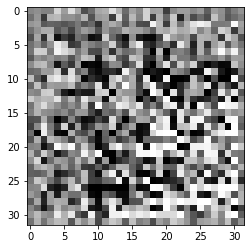



Epoch 362


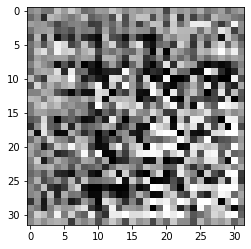



Epoch 363


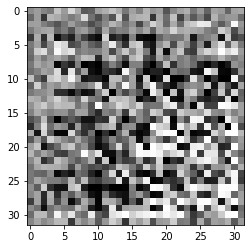



Epoch 364


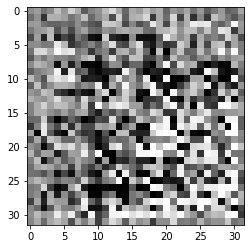



Epoch 365


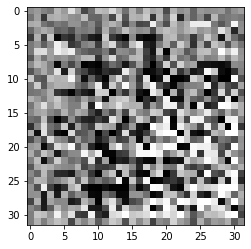



Epoch 366


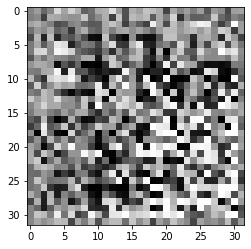



Epoch 367


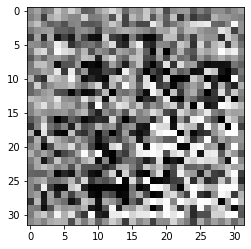



Epoch 368


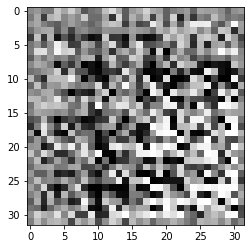



Epoch 369


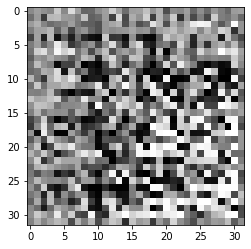



Epoch 370


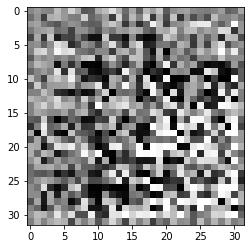



Epoch 371


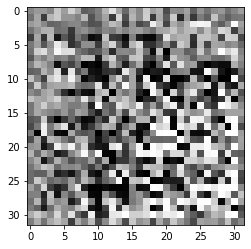



Epoch 372


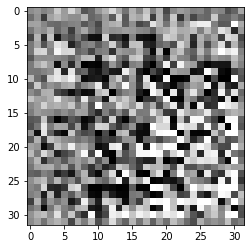



Epoch 373


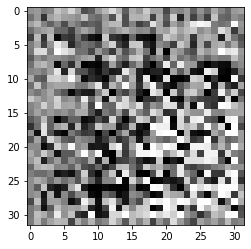



Epoch 374


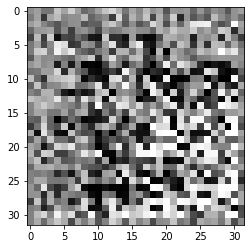



Epoch 375


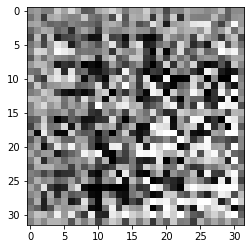



Epoch 376


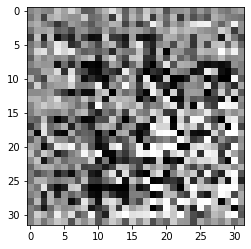



Epoch 377


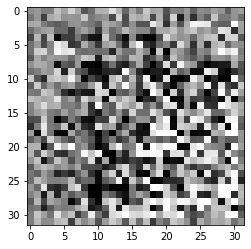



Epoch 378


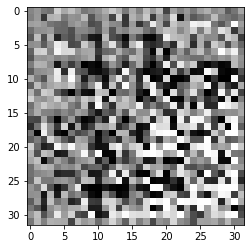



Epoch 379


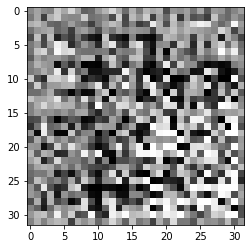



Epoch 380


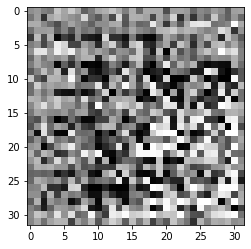



Epoch 381


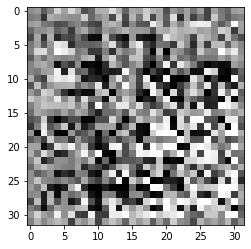



Epoch 382


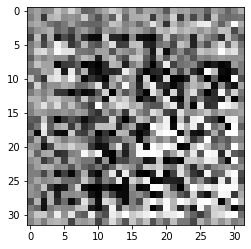



Epoch 383


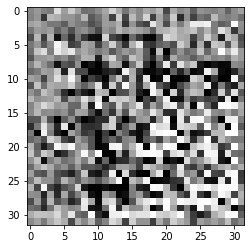



Epoch 384


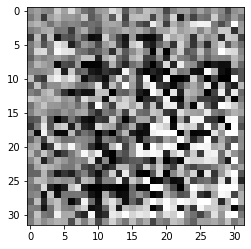



Epoch 385


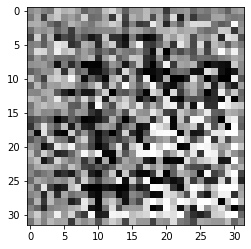



Epoch 386


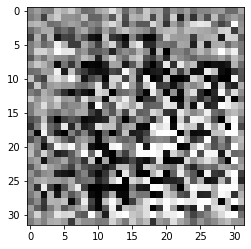



Epoch 387


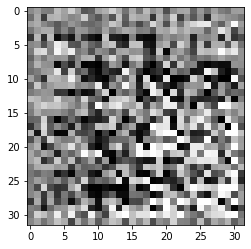



Epoch 388


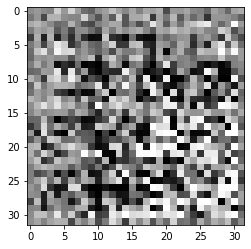



Epoch 389


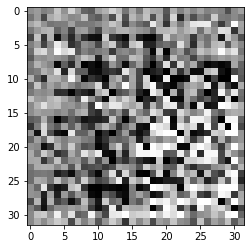



Epoch 390


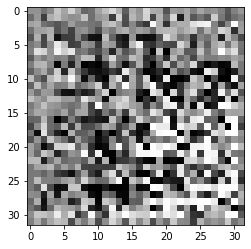



Epoch 391


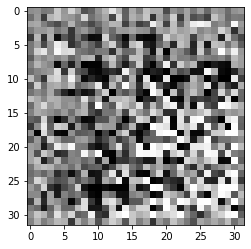



Epoch 392


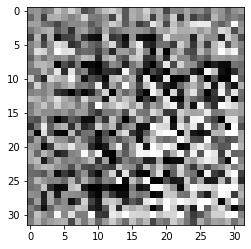



Epoch 393


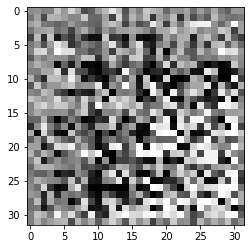



Epoch 394


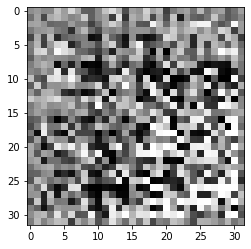



Epoch 395


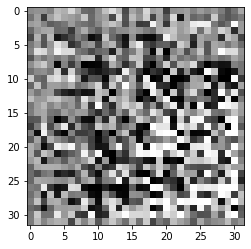



Epoch 396


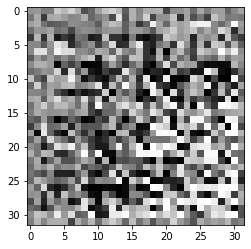



Epoch 397


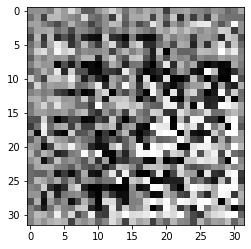



Epoch 398


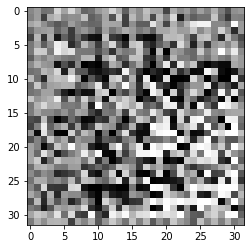



Epoch 399


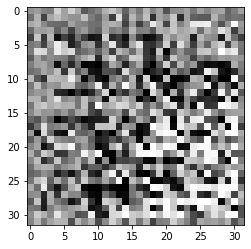



Epoch 400


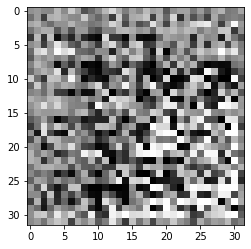



Epoch 401


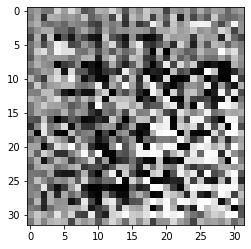



Epoch 402


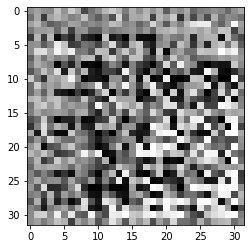



Epoch 403


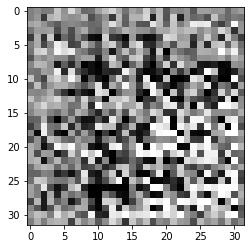



Epoch 404


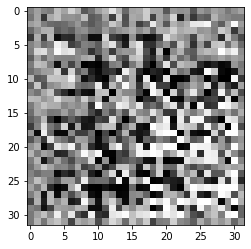



Epoch 405


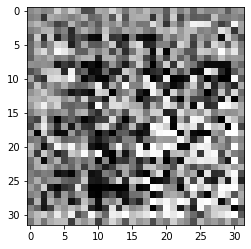



Epoch 406


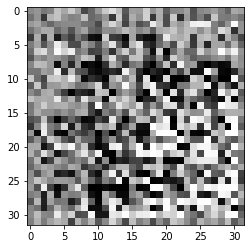



Epoch 407


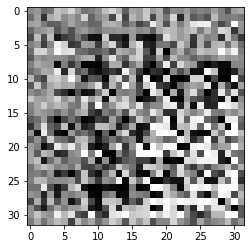



Epoch 408


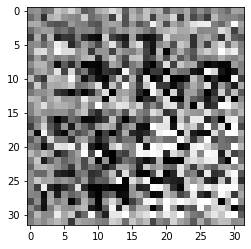



Epoch 409


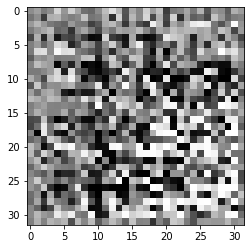



Epoch 410


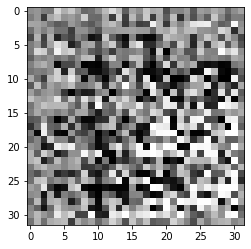



Epoch 411


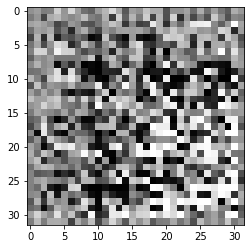



Epoch 412


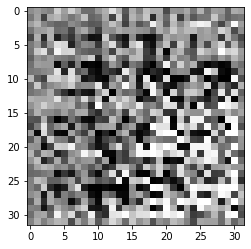



Epoch 413


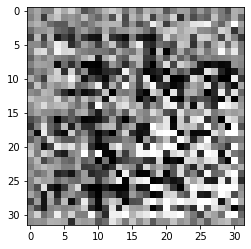



Epoch 414


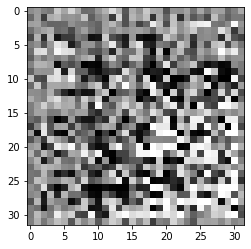



Epoch 415


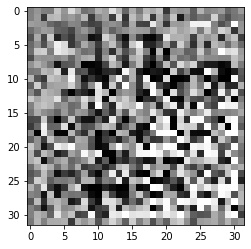



Epoch 416


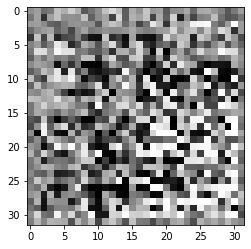



Epoch 417


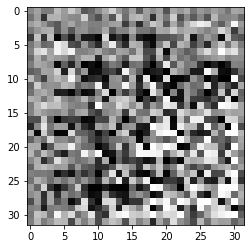



Epoch 418


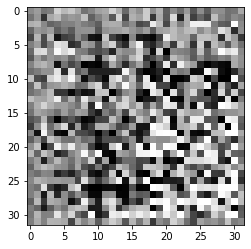



Epoch 419


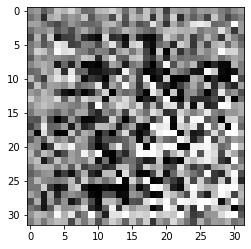



Epoch 420


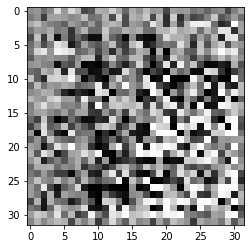



Epoch 421


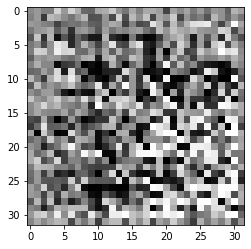



Epoch 422


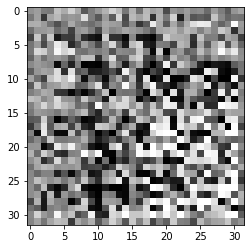



Epoch 423


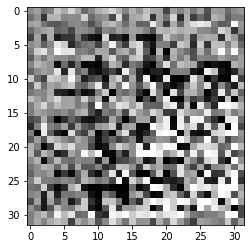



Epoch 424


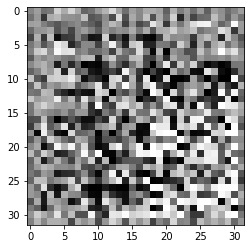



Epoch 425


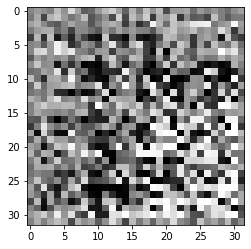



Epoch 426


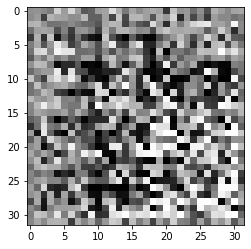



Epoch 427


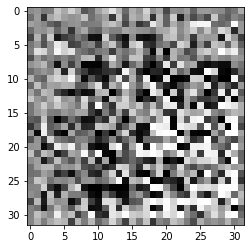



Epoch 428


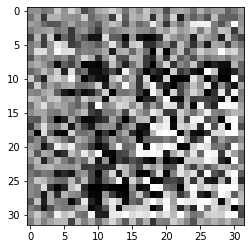



Epoch 429


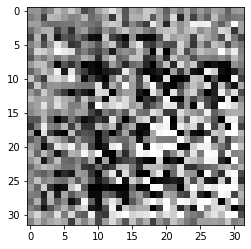



Epoch 430


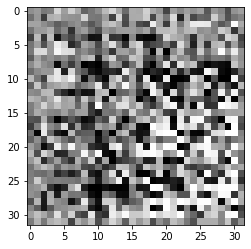



Epoch 431


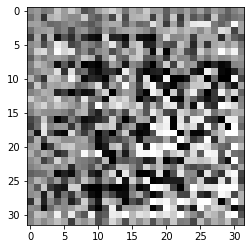



Epoch 432


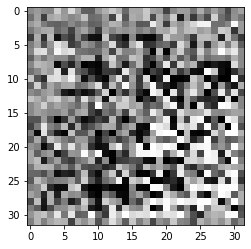



Epoch 433


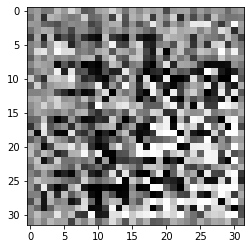



Epoch 434


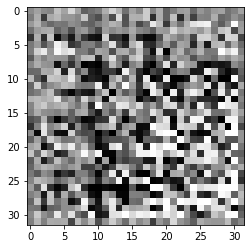



Epoch 435


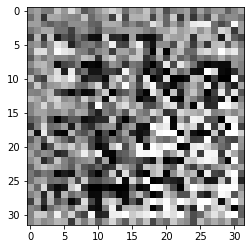



Epoch 436


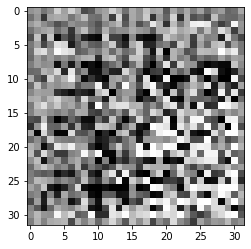



Epoch 437


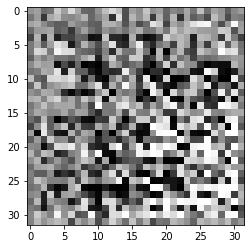



Epoch 438


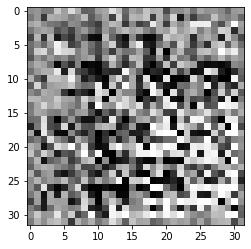



Epoch 439


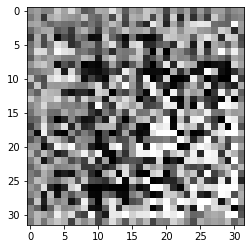



Epoch 440


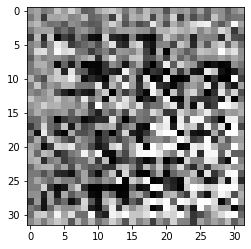



Epoch 441


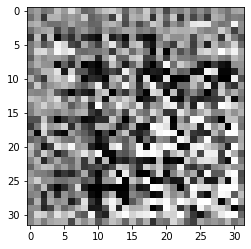



Epoch 442


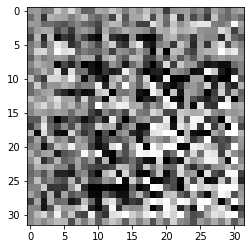



Epoch 443


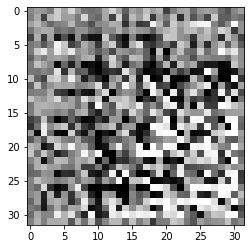



Epoch 444


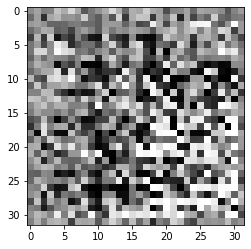



Epoch 445


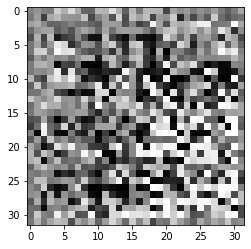



Epoch 446


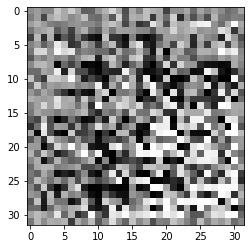



Epoch 447


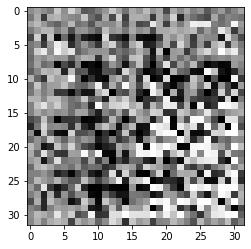



Epoch 448


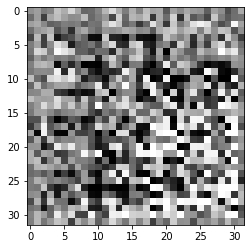



Epoch 449


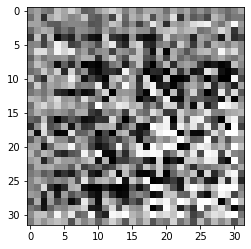



Epoch 450


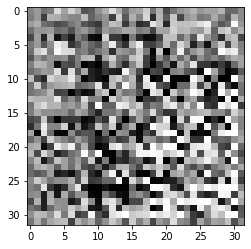



Epoch 451


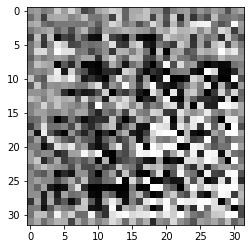



Epoch 452


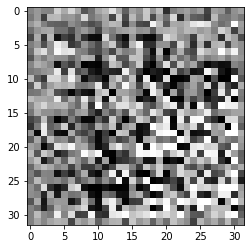



Epoch 453


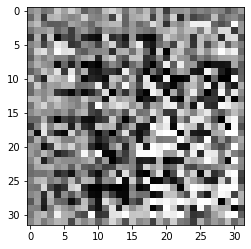



Epoch 454


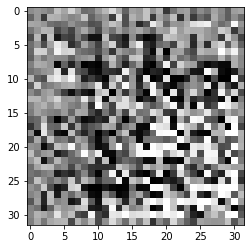



Epoch 455


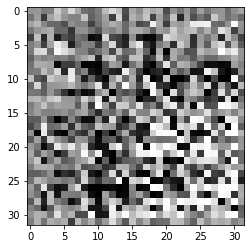



Epoch 456


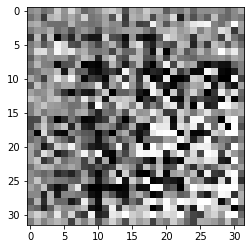



Epoch 457


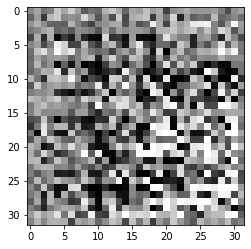



Epoch 458


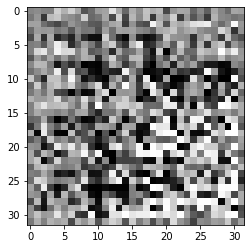



Epoch 459


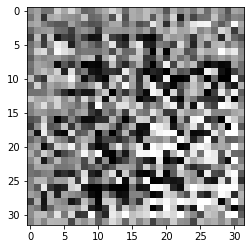



Epoch 460


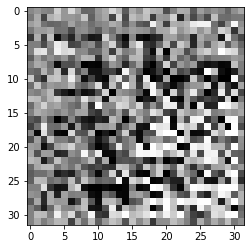



Epoch 461


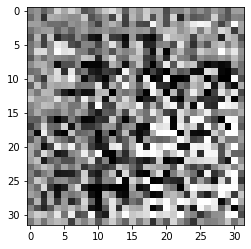



Epoch 462


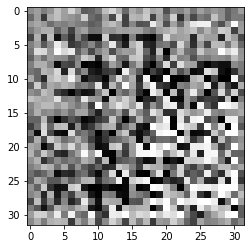



Epoch 463


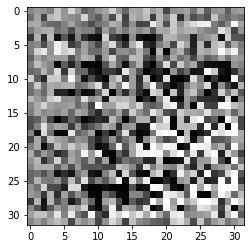



Epoch 464


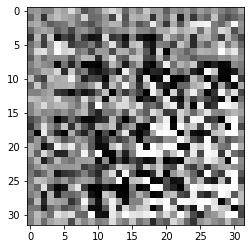



Epoch 465


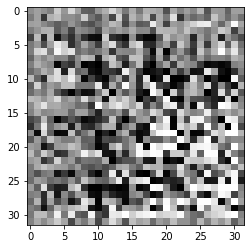



Epoch 466


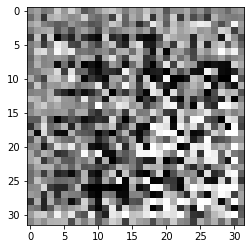



Epoch 467


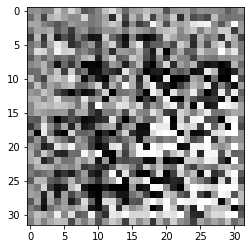



Epoch 468


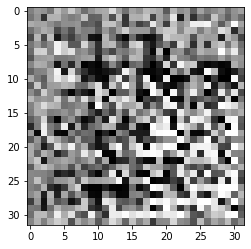



Epoch 469


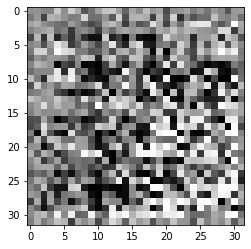



Epoch 470


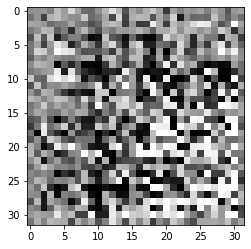



Epoch 471


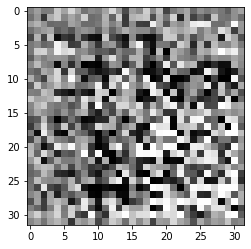



Epoch 472


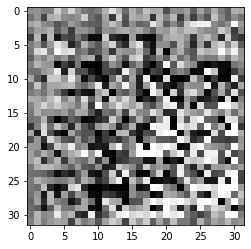



Epoch 473


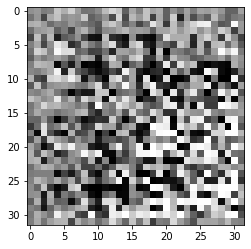



Epoch 474


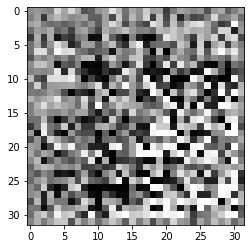



Epoch 475


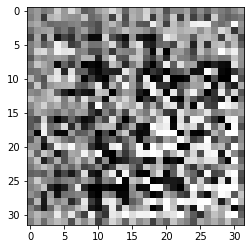



Epoch 476


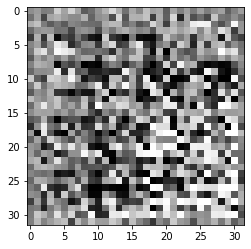



Epoch 477


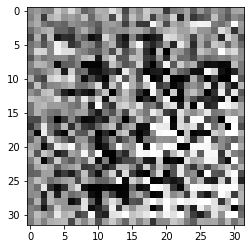



Epoch 478


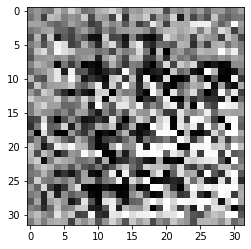



Epoch 479


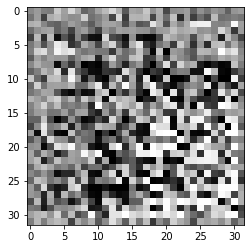



Epoch 480


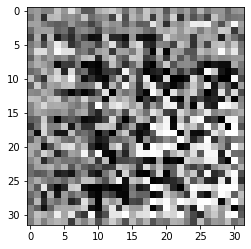



Epoch 481


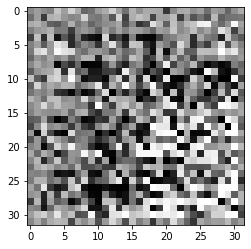



Epoch 482


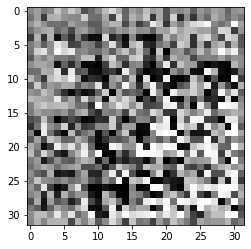



Epoch 483


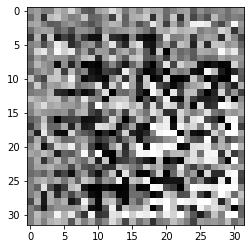



Epoch 484


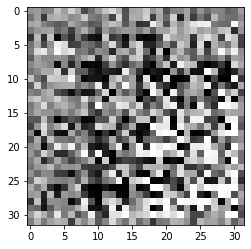



Epoch 485


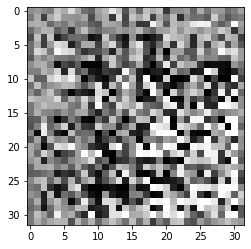



Epoch 486


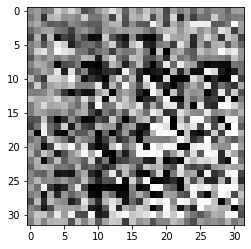



Epoch 487


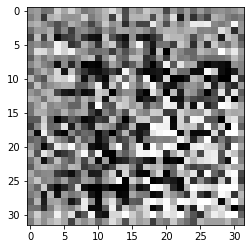



Epoch 488


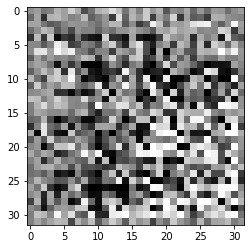



Epoch 489


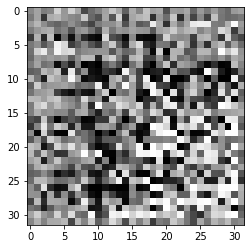



Epoch 490


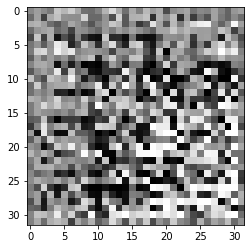



Epoch 491


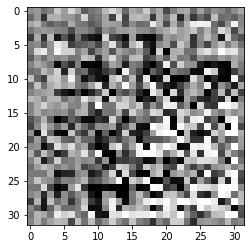



Epoch 492


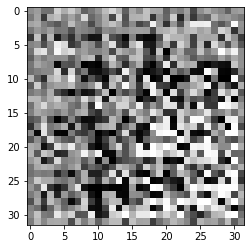



Epoch 493


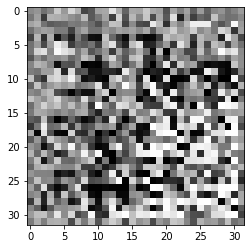



Epoch 494


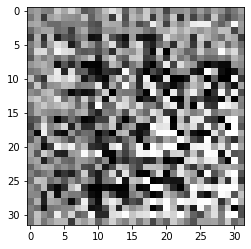



Epoch 495


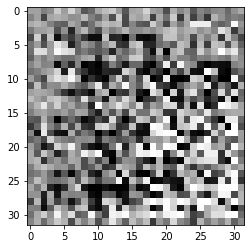



Epoch 496


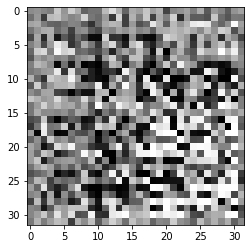



Epoch 497


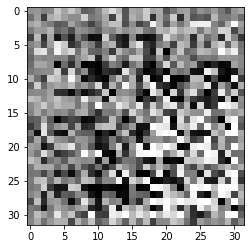



Epoch 498


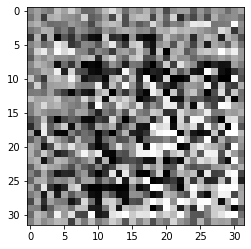



Epoch 499


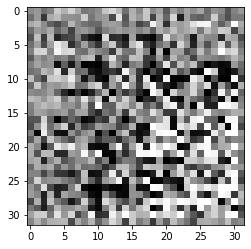



Epoch 500


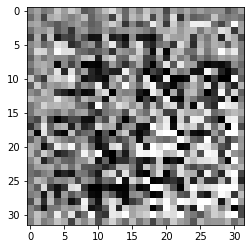

In [10]:
# Train!

gan_model = DCGAN(
    data = img_data,
    batch_size = 128,
    learning_rate = 1e-03,
)

gan_model.train(epochs=500, iterations=100)